In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from math import sqrt,cos,acos,pi,exp,sin,atan2,log
from numpy import arange,mean,asarray,isnan,isinf
import pickle as pkl
from scipy import stats

import csv
import sys
import pandas as pd
import os

from DavioPlotter import *

finalPred = False
fset = 11 # 0 = open data, 1-7 = fake datasets, 8 = High E far sideband, 9 = Low BDT far sideband, 10 = Full near sideband
cutMode = 0 # 0 = Final Selection, 1 = Kin Cut Sample, 2 = High E, 3 = Low BDT, 4 = 
if fset==8: cutMode = 2
if fset==9: cutMode = 3
    
cutmodedir = {0:'FinalSelection',1:'KinCut',2:'HighE',3:'LowBDT'}[cutMode]

lowEpatch = False#True if fset in [0,5,8,9] else False
vtxCut    = 5#np.inf

C1_POT = 1.558e+20 + 1.129e+17 + 1.869e+19
D2_POT = 1.63e+20 + 2.964e+19 + 1.239e+19
E1_POT = 5.923e+19
F1_POT = 4.3e+19
G1_POT = 1.701e+20 + 2.97e+19 + 1.524e+17


if fset==0: 
    DAT_POT1 = 4.403e19
    DAT_POT2 = 0
    DAT_POT3 = 8.786e+18
elif fset==1: 
    DAT_POT1  = 1.935765e20
    DAT_POT2 = 0
    DAT_POT3  = 2.99974063e20
elif fset==2: 
    DAT_POT1 = 4.0129213616e20
    DAT_POT2 = 0
    DAT_POT3 = 3.85169302616e20
elif fset==3: 
    DAT_POT1 = 4.024614415411e20
    DAT_POT2 = 0
    DAT_POT3 = 3.9685728933181e20
elif fset==4: 
    DAT_POT1 = 3.907905653e20
    DAT_POT2 = 0
    DAT_POT3 = 3.92356759e20
elif fset==5: 
    DAT_POT1 = 7.00587e20
    DAT_POT2 = 0
    DAT_POT3 = 0
elif fset==7: 
    DAT_POT1 = 1.8382999360024655e+20
    DAT_POT2 = 0
    DAT_POT3 = 2.05E+20
elif(fset==8):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = F1_POT+G1_POT
elif(fset==9):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = G1_POT
elif(fset ==10):
    DAT_POT1 = 1.631e+20
    DAT_POT2 = 2.750e+20
    DAT_POT3 = 2.291e+20
elif(fset ==11):
    DAT_POT1 = 1.69E+20
    DAT_POT2 = 2.73E+20
    DAT_POT3 = 2.44E+20


if finalPred and fset==0:
    DAT_POT1 = C1_POT
    DAT_POT2 = E1_POT+D2_POT
    DAT_POT3 = F1_POT+G1_POT
    
DATA_POT_TOT = DAT_POT1 + DAT_POT2 + DAT_POT3


print(DAT_POT1,DAT_POT2,DAT_POT3)
print(DAT_POT1+DAT_POT2+DAT_POT3)

def poisson_errors(k, CL = 0.6827):
    
    # 1 Sig = 0.6827
    # 2 Sig = 0.9545
    # 3 Sig = 0.9973
    
    a = 1.0 - CL
    low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
    low = np.where(k==0,0,low)
    return k - low, high - k


1.69e+20 2.73e+20 2.44e+20
6.86e+20


In [9]:
tag='3March2021_vA_fullLowE_withPi0Sample_newShowerCalib'
#tag='7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu'

filetaglist = {1:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0'],
               2:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE'],
               3:['data','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0']}

df = {1:{},2:{},3:{}}

psavedir = 'Parquets/'+tag+'/'

for r in [1,2,3]:
    print('\n\n','#'*20,'RUN',r,'#'*20,'\n')

    for filetag in filetaglist[r]:
        if not lowEpatch and 'lowE' in filetag: continue
        print('Sample:',filetag)
        if filetag=='data':
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        else:
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        try:
            df[r][filetag] = pd.read_parquet(psavedir+pstring)
            print(len(df[r][filetag]))
        except:
            print('No Events')
            pass
        
df[2]['ext'] = df[3]['ext'].copy()
if cutMode in [2,3]:
    df1d = (df[1]['data'].copy()).query('run<8000')
    df2d = (df[1]['data'].copy()).query('run>8000 and run<13000')
    df3d = (df[1]['data'].copy()).query('run>13000')
    df[1]['data'] = df1d
    df[2]['data'] = df2d
    df[3]['data'] = df3d



 #################### RUN 1 #################### 

Sample: data
1549
Sample: ext
263
Sample: overlay
5602
Sample: intrinsics
14733
Sample: ncpi0
589
Sample: ccpi0
285


 #################### RUN 2 #################### 

Sample: data
1989
Sample: ext
No Events
Sample: overlay
5784
Sample: intrinsics
11241


 #################### RUN 3 #################### 

Sample: data
1862
Sample: ext
537
Sample: overlay
3943
Sample: intrinsics
5940
Sample: ncpi0
504
Sample: ccpi0
266


In [10]:
    

varb_names = ['Enu_1e1p','Eta','PT_1e1p','AlphaT_1e1p',
              'SphB_1e1p','PzEnu_1e1p','ChargeNearTrunk',
              'Q0_1e1p','Q3_1e1p','Thetas','Phis','PTRat_1e1p',
              'Proton_ThetaReco','Proton_PhiReco',
              'MinShrFrac','MaxShrFrac',
              'BjXB_1e1p','BjYB_1e1p','Proton_Edep',
              'Electron_Edep',
              'Lepton_ThetaReco','Lepton_PhiReco',
              'OpenAng','Xreco','Yreco','Zreco',
              'sigprob','MPIDY_muon',
              'MPIDY_proton','MPIDY_eminus','shower_fraction',
              'Shower_Consistency',
              'EnuQE_lepton','EnuQE_proton',
              'Proton_TrackLength','Lepton_TrackLength','EnuTrue']

var_labels = [r'$E_\nu^{Range}$ [MeV]',r'$\eta$',r'Event $p_T$ [MeV]',r'$\alpha_T$',
              'QE Consistency',r'$p_z - E_\nu$ [MeV]','Charge Near Trunk',
              r'$Q_0$ [MeV]',r'$Q_3$ [MeV]',r'$\theta_e + \theta_p$',r'$|\phi_e - \phi_p|$',r'Event $p_T/p$',
              r'$\theta_p$',r'$\phi_p$',
              'Minimum Shower Fraction','Maximum Shower Fraction',
              'Bjorken X (Nucleon Rest Frame)','Bjorken Y (Nucleon Rest Frame)',r'$E_p$ [MeV]',
              r'$E_e$ [MeV]',
              r'$\theta_e$',r'$\phi_e$',
              'Opening Angle',r'$X_{reco}$',r'$Y_{reco}$','$Z_{reco}$',
              '1e1p BDT Score','Muon MPID Score (Y plane)',
              'Proton MPID Score (Y plane)','Electron MPID Score (Y plane)','Shower Fraction',
              'Shower Energy Consistency',
              r'$E_\nu^{Q-e}$',r'$E_\nu^{QE-p}$',
              'Proton Track Length [cm]','Lepton Track Length [cm]',r'$E_\nu^{True}$ [MeV]']

ranges = [ (0,1200),(0,0.6),(0,800),(0,np.pi),(0,5000),(-800,300),
           (0,800),(100,700),(0,1400),(0,2*np.pi),(0,2*np.pi),
           (0,1),(0,np.pi),(-np.pi,np.pi),(-1,1),(-1,1),(0,3),
           (0,1),(60,500),(35,1200),(0,np.pi),
           (-np.pi,np.pi),(0,np.pi),(0,256),(-117,117),(0,1036),
           (0.0,1.0),(0,1),(0,1),(0,1),(0,3),(0,5),
           (0,1200),(0,1200),(0,100),(0,200),(0,1200)]

varlabel_dict = {name:label for name,label in zip(varb_names,var_labels)}
range_dict = {name:rnge for name,rnge in zip(varb_names,ranges)}

if cutMode in [0,2]: range_dict['sigprob'] = (0.95,1.0)
    

In [19]:
# HELPER FUNCTIONS
detsystag = '2August2021'

def getSysErrors(nbins,varName,mode,sigcut,rwtnameoverride=None,nsbmode=0):
    if nsbmode in [1,2,3]: 
        if nsbmode!=3: det_sys_m = np.loadtxt('CovMatrices/DetVar/'+tag+'/14July2021/covMatrix/'+mode+'/BDTcut'+str(sigcut)+'/nsbmode'+str(nsbmode)+'/detsys_'+varName+'_run13_cutMode'+str(cutMode)+'_cov_smooth.csv',delimiter=',')
        if nsbmode==3: det_sys_m = np.loadtxt('CovMatrices/DetVar/'+tag+'/'+detsystag+'/covMatrix/'+mode+'/BDTcut0.95/detsys_'+varName+'_run13_cutMode'+str(cutMode)+'_cov_smooth.csv',delimiter=',')
        elif varName=='Enu_1e1p':
            det_sys_tmp = np.zeros((12,12))
            if nsbmode==1: det_sys_tmp[5:,5:] = det_sys_m
            if nsbmode==2: det_sys_tmp[5:7,5:7] = det_sys_m
            det_sys_m = det_sys_tmp
    else: det_sys_m = np.loadtxt('CovMatrices/DetVar/'+tag+'/'+detsystag+'/covMatrix/'+mode+'/BDTcut'+str(sigcut)+'/detsys_'+varName+'_run13_cutMode'+str(cutMode)+'_cov_smooth.csv',delimiter=',')

    if rwtnameoverride is not None:
        rwt_sys_m = np.loadtxt('CovMatrices/RwghtSys/frac_covar_rewgt_'+rwtnameoverride+'__'+varName+'.txt')
    else:
        if varName=='sigprob': varName='sigprobavg'
        rwt_sys_m = np.loadtxt('CovMatrices/RwghtSys/frac_covar_rewgt_'+cutmodedir+'__'+varName+'.txt')
        

    rwt_sys_m = np.where(np.isnan(rwt_sys_m),0,rwt_sys_m)
    det_sys_m = np.where(np.isnan(det_sys_m),0,det_sys_m)
    return rwt_sys_m,det_sys_m

def getDetSysTot(det_sys_nue,nue,numu):
    print(det_sys_nue)
    det_sys_numu = np.diag(0.04*np.ones(det_sys_nue.shape[0]))
    print(det_sys_numu)
    print(nue)
    print(numu)
    tot = nue+numu
    return (det_sys_nue * np.outer(nue,nue) + det_sys_numu * np.outer(numu,numu))/np.outer(tot,tot)
    

def MakeBDTcut(idf,sigcut,mode,nBDTs,r2overlay=False,ttc=0.1):
    
    # Conglemerate BDT scores and weights based on strategy 
    
    bdtweight = np.zeros(idf.shape[0])
    sigprobmax = np.zeros(idf.shape[0]) 
    sigprobavg = np.zeros(idf.shape[0])
    sigprobmedian = np.zeros(idf.shape[0])
    sigproblist = np.zeros((idf.shape[0],nBDTs))
    notintrain = np.zeros((idf.shape[0],nBDTs),dtype=bool)
    numnottrain = np.zeros(idf.shape[0])
    for b in range(nBDTs):
        sp = idf['sigprob%i'%b]
        tvw = idf['tvweight%i'%b]
        sigprobmax = np.where(np.logical_and(tvw>0,sp>sigprobmax),sp,sigprobmax) # cut on the maximum non-train score in ensemble
        if mode == 'fracweight': 
            #bdtweight += np.where(sp>sigcut,tvw/float(nBDTs),0)
            bdtweight += np.where((tvw>ttc) & (sp>sigcut),1.0,0.0)
        sigprobavg += np.where(tvw>ttc,sp,0)
        numnottrain += np.where(tvw>ttc,1,0)
        sigproblist[:,b] = sp
        notintrain[:,b] = tvw > ttc
    sigprobavg /= np.where(numnottrain>0,numnottrain,1)
    for i,(tlist,siglist) in enumerate(zip(notintrain,sigproblist)):
        splist = siglist[tlist]
        if splist.size!=0: sigprobmedian[i] = np.median(splist)
        else: sigprobmedian[i] = 0
        
    idf['sigprobavg'] = sigprobavg
    idf['sigprobmedian'] = sigprobmedian
    idf['sigprobmax'] = sigprobmax

    
    if mode == 'avgscore':
        idf['sigprob'] = idf['sigprobavg']
        bdtweight = np.where(sigprobavg>sigcut,1,0)
    elif mode == 'medianscore':
        idf['sigprob'] = idf['sigprobmedian']
        bdtweight = np.where(sigprobmedian>sigcut,1,0)
    elif mode == 'fracweight':
        idf['sigprob'] = idf['sigprobmax']
        bdtweight /= np.where(numnottrain>0,numnottrain,1)
    
    idf['bdtweight'] = bdtweight
    
    # Drop duplicates
    
    idf.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
    if r2overlay:
        idf.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
    else:
        idf.drop_duplicates(subset=['run','subrun','event'],inplace=True)
    
def SaveTextFile(idf,run,filetag,sigcut,mode,tsavedir):
    nBDTs = int(idf['nBDTs'][0])
    MakeBDTcut(idf,sigcut,mode,nBDTs)
    idf.query('sigprob > @sigcut',inplace=True)
    savestr = 'eventlist_%s_run%i.txt'%(filetag,run)
    idf.to_csv(tsavedir+savestr,index=None,sep=' ')
    
    

In [20]:
mu_cutoff = 0.46149198646840239

def chi2_cnp(M,mu):
    c2c=0
    if mu>0:
        if M != 0:
            c2c = (M - mu)**2/(3 / (2 / mu + 1 / M))
        else:
            c2c = mu/2#(M - mu)**2/(3 / (2 / mu + 1 / mu))
    return c2c

def chi2_pois(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = 2*(mu - M + M*np.log(M/mu))
        else:
            c2c = 2*mu
    return c2c

def chi2_pears(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = (M-mu)**2 / mu
        else:
            c2c = 2*mu
    return c2c

def chi2_thresh(M,mu,mode='cnp'):
    c2c=0
    if mu > mu_cutoff and mode=='cnp':
        c2c = chi2_cnp(M,mu)
    elif mu > mu_cutoff and mode=='pearson':
        c2c = chi2_pears(M,mu)
    else:
        c2c = chi2_pois(M,mu)
    return c2c

def cov_pois(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (M-mu)**2 / (2*(mu - M + M*np.log(M/mu)))
        else:
            cov = mu/2
    return cov

def cov_cnp(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (3 / (2 / mu + 1 / M))
        else:
            cov = mu/2
    return cov

def cov_pears(M,mu):
    cov=0
    if mu > 0:
        cov = mu
    return cov

def cov_thresh(M,mu,mode='cnp'):
    cov=0
    if mu>mu_cutoff and mode=='cnp':
        cov=cov_cnp(M,mu)
    elif mu>mu_cutoff and mode=='pearson':
        cov=cov_pears(M,mu)
    else:
        cov=cov_pois(M,mu)
    return cov


[[ 0.1378435   0.06243347  0.05324877  0.05016148  0.04012925  0.03318021
   0.02613677  0.02350933  0.00703214 -0.02980322 -0.06010812 -0.06374192]
 [ 0.06243347  0.04020348  0.03370984  0.03160476  0.02770264  0.0206537
   0.00852278  0.00441232  0.00885924 -0.00031219 -0.0161153  -0.02515946]
 [ 0.05324877  0.03370984  0.02938008  0.02778837  0.02464003  0.01889867
   0.00788893  0.00262683  0.00513328 -0.00202218 -0.01446356 -0.02124438]
 [ 0.05016148  0.03160476  0.02778837  0.02755754  0.02459406  0.01825702
   0.00659337  0.00180591  0.00500055 -0.00205971 -0.01486232 -0.02178745]
 [ 0.04012925  0.02770264  0.02464003  0.02459406  0.02274361  0.01673747
   0.0046968  -0.00073159  0.00457674  0.00124987 -0.00877369 -0.01539683]
 [ 0.03318021  0.0206537   0.01889867  0.01825702  0.01673747  0.0136923
   0.0057267   0.00032592  0.00149247 -0.00157937 -0.00883364 -0.01331268]
 [ 0.02613677  0.00852278  0.00788893  0.00659337  0.0046968   0.0057267
   0.00750856  0.00625193 -0.001294

/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide
/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:518: RuntimeWarning: invalid value encountered in divide
/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:568: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 432x288 with 0 Axes>

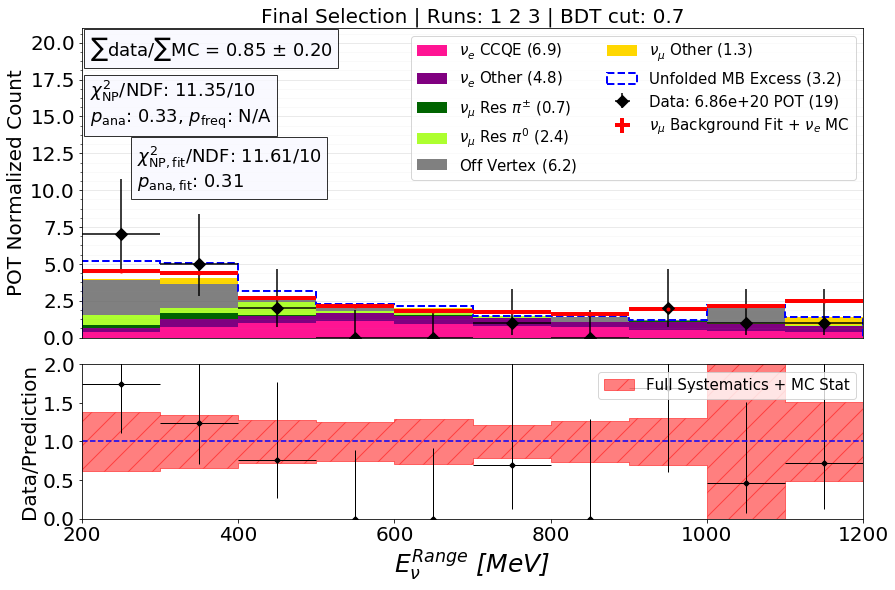

[[ 0.01764877  0.0094992   0.00486822  0.0006467   0.00045848  0.00310617
   0.00711948  0.00975851  0.00373984 -0.0074928 ]
 [ 0.0094992   0.01818419  0.0155109   0.00559359 -0.00065422 -0.00561178
  -0.01362857 -0.02160666 -0.02571871 -0.01698579]
 [ 0.00486822  0.0155109   0.01616468  0.00894167  0.00134006 -0.00535114
  -0.01486008 -0.02206884 -0.02221748 -0.01050395]
 [ 0.0006467   0.00559359  0.00894167  0.00869338  0.00433125 -0.00010258
  -0.00583261 -0.00863498 -0.00611882 -0.00052042]
 [ 0.00045848 -0.00065422  0.00134006  0.00433125  0.0052557   0.00443926
   0.0018705  -0.00031599 -0.00101673 -0.00248354]
 [ 0.00310617 -0.00561178 -0.00535114 -0.00010258  0.00443926  0.00894305
   0.01359561  0.0154316   0.01217426  0.00115066]
 [ 0.00711948 -0.01362857 -0.01486008 -0.00583261  0.0018705   0.01359561
   0.0315604   0.04529525  0.04307124  0.01725078]
 [ 0.00975851 -0.02160666 -0.02206884 -0.00863498 -0.00031599  0.0154316
   0.04529525  0.07569736  0.08062347  0.04310727]
 

<Figure size 432x288 with 0 Axes>

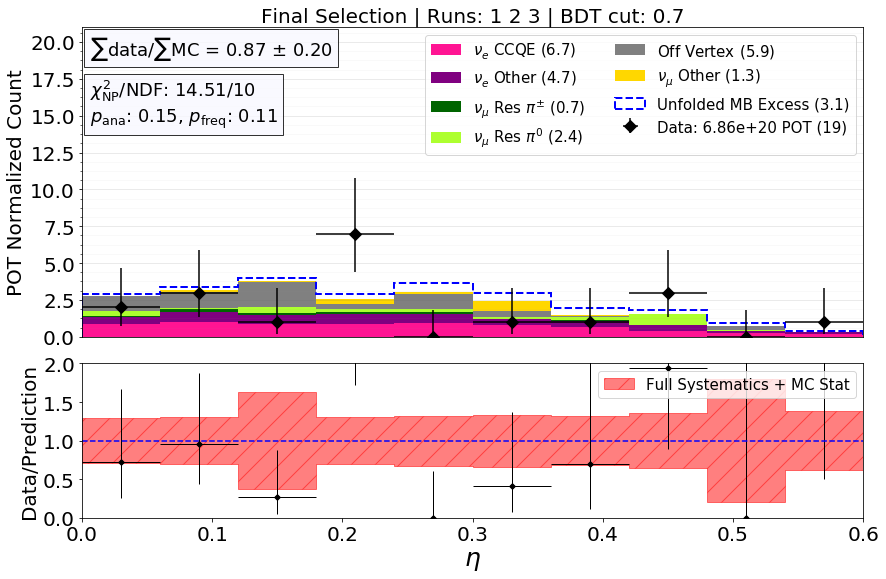

[[ 7.28353266e-02  3.57851177e-02  5.24122770e-04 -3.01282271e-02
  -4.20456164e-02 -8.25435275e-03  1.50385907e-02  1.82813803e-01
   3.70665164e+00  1.05032714e+03]
 [ 3.57851177e-02  1.90857587e-02  2.25929677e-03 -1.33925627e-02
  -1.91031121e-02 -2.66175195e-03  5.01323698e-03  7.71223028e-02
   1.74712432e+00  4.37413578e+02]
 [ 5.24122770e-04  2.25929677e-03  3.40493521e-03  3.12392853e-03
   2.84348794e-03  1.76383383e-03  5.91373393e-04 -1.01051763e-02
  -7.69011318e-02 -1.33042928e+02]
 [-3.01282271e-02 -1.33925627e-02  3.12392853e-03  1.69597639e-02
   2.14312093e-02  5.35154180e-03  3.76207580e-03 -6.86621088e-02
  -1.63680133e+00 -6.35561356e+02]
 [-4.20456164e-02 -1.91031121e-02  2.84348794e-03  2.14312093e-02
   3.03154078e-02  7.50741046e-03 -1.69066433e-03 -1.22898903e-01
  -2.69461727e+00 -9.94574239e+02]
 [-8.25435275e-03 -2.66175195e-03  1.76383383e-03  5.35154180e-03
   7.50741046e-03  5.55593031e-03  8.58268702e-03 -1.76894444e-02
  -4.54210134e-01 -2.86614362e+02

<Figure size 432x288 with 0 Axes>

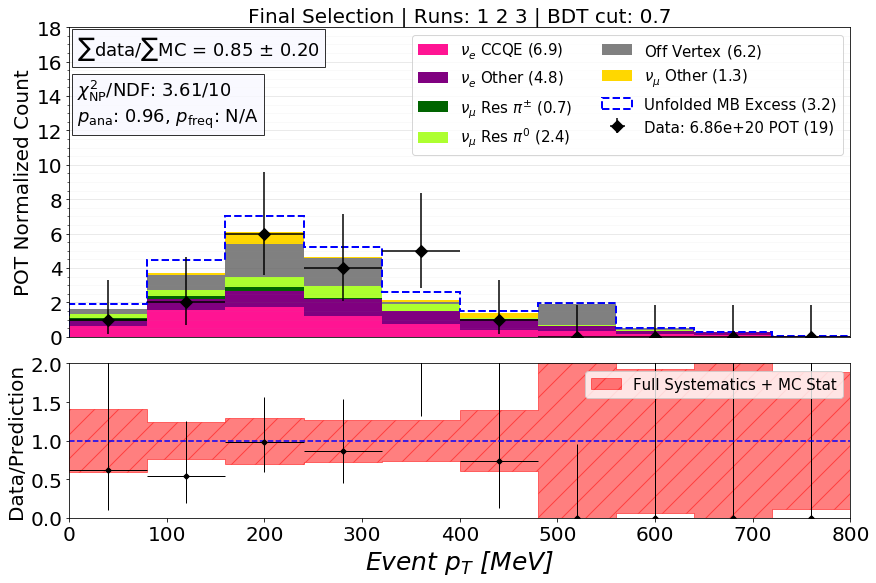

[[ 0.03383594  0.03986289  0.033272    0.01359319  0.00087637 -0.00789672
  -0.01343291 -0.00608655 -0.00134773  0.00821315]
 [ 0.03986289  0.05462138  0.04670372  0.01767456 -0.00198129 -0.01380718
  -0.01988481 -0.00880795 -0.00286377  0.00811953]
 [ 0.033272    0.04670372  0.0429341   0.01772038 -0.00134056 -0.01167395
  -0.01605301 -0.00491179 -0.00028937  0.00738464]
 [ 0.01359319  0.01767456  0.01772038  0.01037163  0.00390376 -0.00097108
  -0.00363275 -0.00016535  0.00035023  0.00311209]
 [ 0.00087637 -0.00198129 -0.00134056  0.00390376  0.00877903  0.00778226
   0.00477529  0.00068524 -0.00288038 -0.00268224]
 [-0.00789672 -0.01380718 -0.01167395 -0.00097108  0.00778226  0.01022837
   0.00929036  0.0033581  -0.0010749  -0.00395202]
 [-0.01343291 -0.01988481 -0.01605301 -0.00363275  0.00477529  0.00929036
   0.01188326  0.00802056  0.00478515 -0.00120419]
 [-0.00608655 -0.00880795 -0.00491179 -0.00016535  0.00068524  0.0033581
   0.00802056  0.01072166  0.01089764  0.00498225]
 

<Figure size 432x288 with 0 Axes>

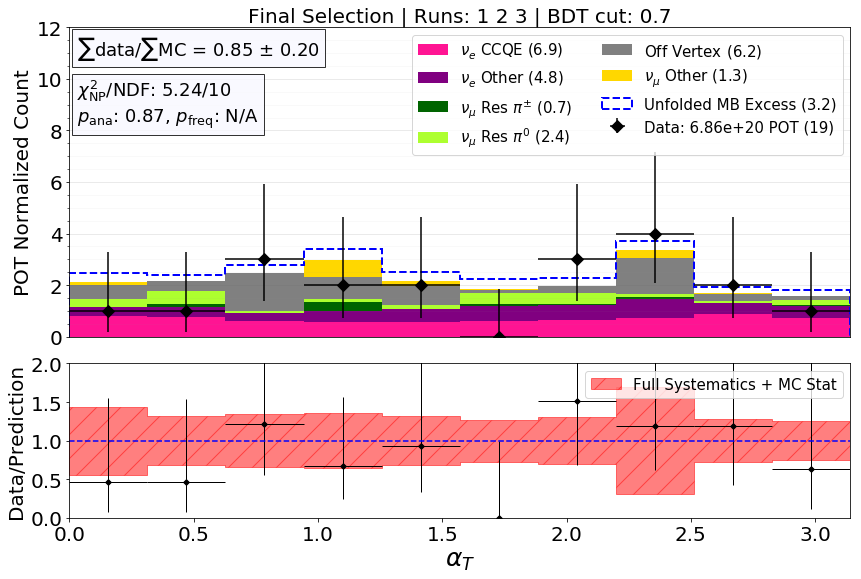

[[ 0.01206244  0.00397725 -0.0161609  -0.00414447  0.03547548  0.05170446
   0.0199624   0.01471492  0.02641798  0.00927439]
 [ 0.00397725  0.00581322  0.00298828 -0.01114032 -0.01838834 -0.00899652
  -0.00734402 -0.00348634  0.00615755  0.01563604]
 [-0.0161609   0.00298828  0.05072787  0.02755535 -0.04897298 -0.07200743
  -0.02204067 -0.00683909 -0.0293102  -0.02516555]
 [-0.00414447 -0.01114032  0.02755535  0.34826986  0.64147737  0.45175596
   0.26462226  0.36246863  0.39104604  0.06367354]
 [ 0.03547548 -0.01838834 -0.04897298  0.64147737  1.60040339  1.30253496
   0.64463501  0.7009222   0.72695712  0.10496587]
 [ 0.05170446 -0.00899652 -0.07200743  0.45175596  1.30253496  1.29706223
   0.69474024  0.54317916  0.42722439 -0.05552629]
 [ 0.0199624  -0.00734402 -0.02204067  0.26462226  0.64463501  0.69474024
   0.47783613  0.4149635   0.27522568 -0.06599216]
 [ 0.01471492 -0.00348634 -0.00683909  0.36246863  0.7009222   0.54317916
   0.4149635   0.64714622  0.68650079  0.19341475]


<Figure size 432x288 with 0 Axes>

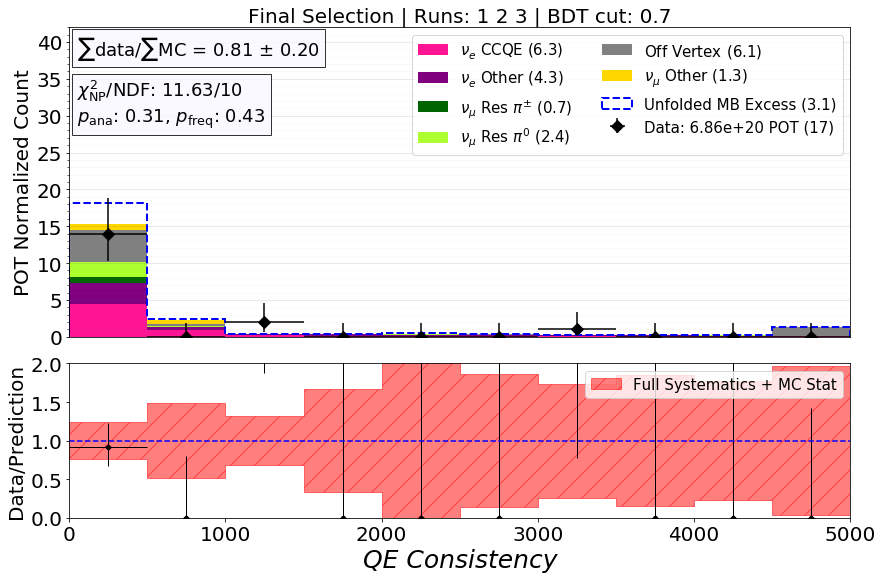

[[ 2.48328967e-01  1.37813659e-01  2.98816025e-01  1.47479181e-01
   2.26627078e-02  1.82806225e-03 -3.53269562e-03 -1.41750541e-02
  -3.02513168e-02 -5.95509262e-02]
 [ 1.37813659e-01  2.06686422e+01  2.25480572e+00  9.01526358e-01
   4.24816588e-01  2.45222921e-01  1.49254764e-01  2.76122400e-02
  -4.79450651e-02 -8.36220949e-04]
 [ 2.98816025e-01  2.25480572e+00  5.44522021e-01  1.92803628e-01
   3.71427304e-02  7.99116703e-03 -1.27818406e-02 -2.51809503e-02
  -1.86525654e-02  1.26651990e-02]
 [ 1.47479181e-01  9.01526358e-01  1.92803628e-01  1.19305811e-01
   6.02799239e-02  2.94724766e-02  8.92464901e-03 -8.31616242e-03
  -1.82016499e-02 -2.04155488e-02]
 [ 2.26627078e-02  4.24816588e-01  3.71427304e-02  6.02799239e-02
   5.36628455e-02  3.23520637e-02  1.68064859e-02  2.05204735e-03
  -1.01450311e-02 -2.25978109e-02]
 [ 1.82806225e-03  2.45222921e-01  7.99116703e-03  2.94724766e-02
   3.23520637e-02  2.14546075e-02  1.20841965e-02  3.10568603e-03
  -4.42902087e-03 -1.37263620e-02

<Figure size 432x288 with 0 Axes>

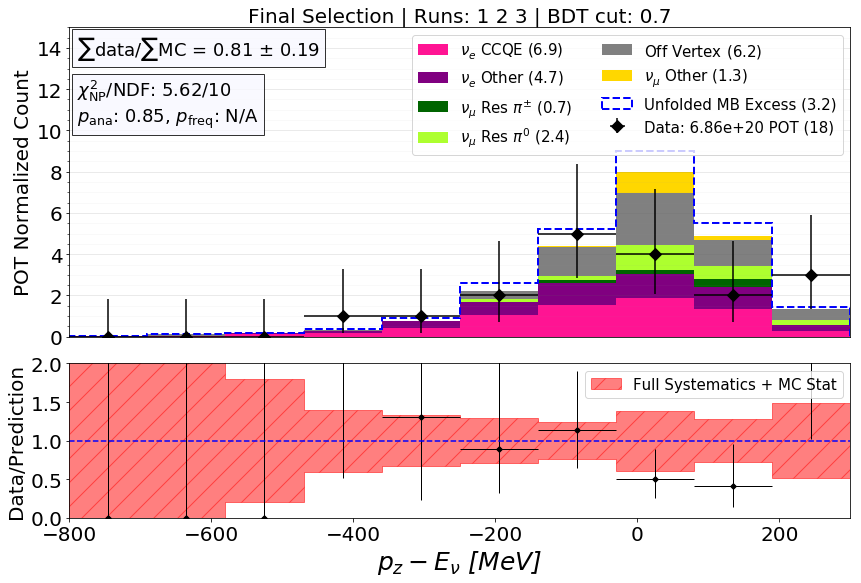

[[ 1.37772348e-01  1.60259266e-01  3.19979605e-02  1.52442984e-02
   7.04106504e-03 -1.82395431e-02 -6.71960608e-02 -1.38557329e-01
  -1.18339566e-01 -5.70126314e-02]
 [ 1.60259266e-01  3.15145183e-01  3.26854371e-02  9.64684340e-04
   1.72372341e-03 -3.46594732e-02 -1.31462886e-01 -2.53804180e-01
  -1.88469193e-01 -4.15126174e-02]
 [ 3.19979605e-02  3.26854371e-02  6.13561388e-02  4.23561300e-02
   1.97201070e-02 -9.70655784e-03 -4.76890879e-02 -8.12523457e-02
  -6.46919002e-02  7.82013852e-02]
 [ 1.52442984e-02  9.64684340e-04  4.23561300e-02  3.32336419e-02
   1.65969420e-02 -3.92740227e-03 -2.77738619e-02 -4.76232252e-02
  -4.19584019e-02  4.03850023e-02]
 [ 7.04106504e-03  1.72372341e-03  1.97201070e-02  1.65969420e-02
   1.02628772e-02 -3.42573961e-04 -1.62628979e-02 -2.91773260e-02
  -2.43450001e-02  6.56257657e-03]
 [-1.82395431e-02 -3.46594732e-02 -9.70655784e-03 -3.92740227e-03
  -3.42573961e-04  6.39078985e-03  1.74255650e-02  3.15220803e-02
   2.12062349e-02 -1.83832341e-02

<Figure size 432x288 with 0 Axes>

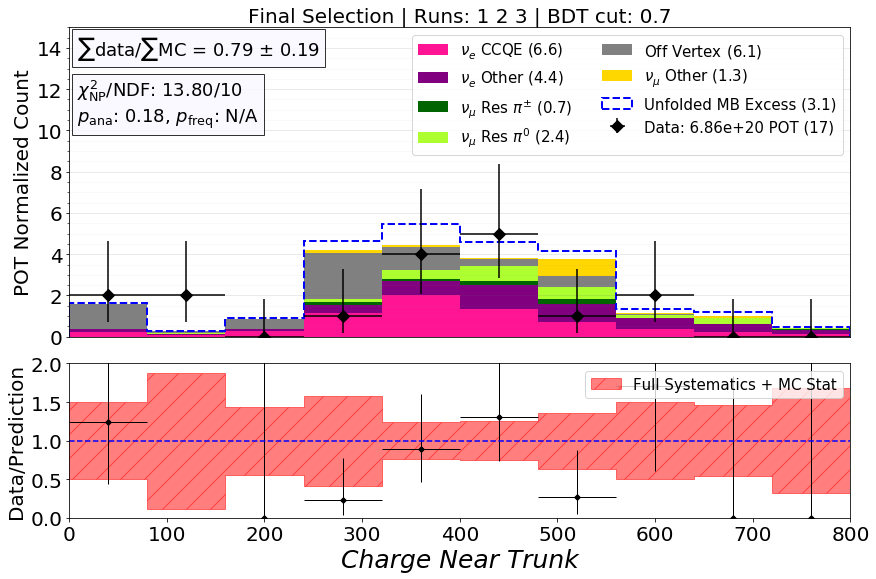

[[ 5.65713058e-03  4.95011231e-03  2.70896953e-04 -5.00964127e-03
  -5.66045602e-03 -9.64118216e-03 -1.81488779e-02 -1.02431609e-02
  -4.34660001e-02 -9.21978490e+03]
 [ 4.95011231e-03  5.90082385e-03  4.48237137e-03  2.73054039e-03
  -1.15895489e-04 -8.02968805e-03 -1.21589780e-02  2.19197016e-02
   1.20349799e-01  4.02284526e+04]
 [ 2.70896953e-04  4.48237137e-03  2.25408918e-02  4.41622017e-02
   2.80707559e-02  6.56976347e-03  5.21477682e-02  2.22682876e-01
   1.12120722e+00  3.99845450e+05]
 [-5.00964127e-03  2.73054039e-03  4.41622017e-02  9.73451747e-02
   6.65885850e-02  2.94892267e-02  1.44309555e-01  4.90543365e-01
   2.41130357e+00  7.02252941e+05]
 [-5.66045602e-03 -1.15895489e-04  2.80707559e-02  6.65885850e-02
   5.44986672e-02  4.27092486e-02  1.31763679e-01  3.22474656e-01
   1.50526629e+00 -6.05150334e-03]
 [-9.64118216e-03 -8.02968805e-03  6.56976347e-03  2.94892267e-02
   4.27092486e-02  9.24895848e-02  1.87119458e-01  1.19350936e-01
  -4.49846797e-02 -2.14919514e-02

<Figure size 432x288 with 0 Axes>

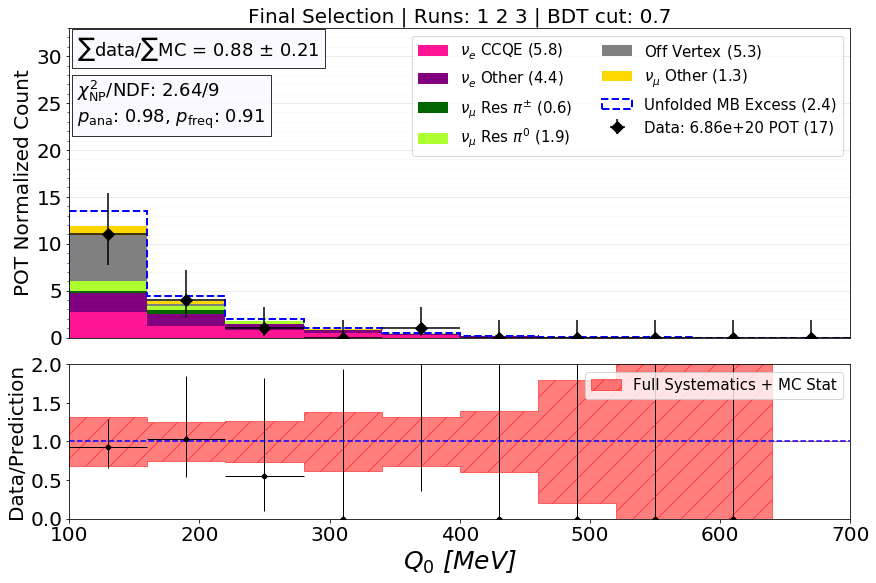

[[ 3.10927570e-02  5.80119767e-03  2.08848862e-03  2.62334694e-03
   4.12389773e-03  6.81719281e-04 -8.09654747e-03 -2.95361636e-03
   7.25178741e-02  1.76769001e+00]
 [ 5.80119767e-03  1.95325147e-02  1.02139098e-02  2.52227016e-03
  -9.13933744e-03 -1.83157025e-02 -3.24561224e-03  3.57211817e-03
  -8.55432123e-02 -7.95341663e-01]
 [ 2.08848862e-03  1.02139098e-02  9.59468971e-03  6.67170134e-03
   1.72228447e-04 -7.34262560e-03 -6.11582268e-03 -6.74937283e-03
  -4.73726285e-02 -4.57597565e-01]
 [ 2.62334694e-03  2.52227016e-03  6.67170134e-03  8.21103621e-03
   8.05787568e-03  3.56336801e-03 -7.27271116e-03 -1.63773875e-02
  -1.23409037e-02  1.72658809e-01]
 [ 4.12389773e-03 -9.13933744e-03  1.72228447e-04  8.05787568e-03
   1.99231984e-02  2.35195051e-02 -5.67984628e-03 -2.83300838e-02
   7.04190748e-02  1.84590265e+00]
 [ 6.81719281e-04 -1.83157025e-02 -7.34262560e-03  3.56336801e-03
   2.35195051e-02  3.65696555e-02  1.50680219e-03 -3.07881231e-02
   1.26086776e-01  3.17315178e+00

<Figure size 432x288 with 0 Axes>

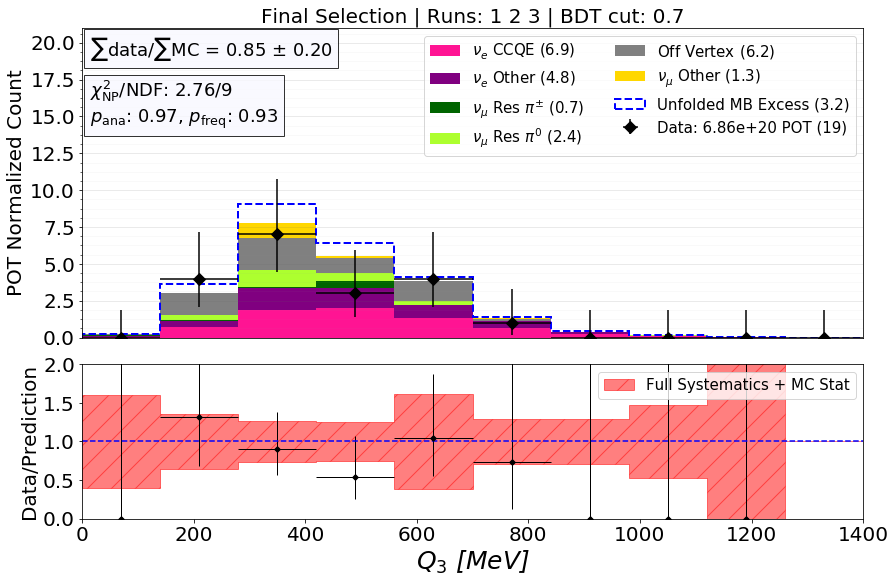

[[ 3.38148845e-03  1.87829600e-03  7.55120391e-04 -1.39017727e-04
  -9.71140493e-04 -9.92489275e-04  2.28062242e-03  5.12337601e-03
   8.12187950e-03  1.01649458e-02]
 [ 1.87829600e-03  2.48683401e-03  3.13789156e-03  3.50417561e-03
   3.36013935e-03  3.18647508e-03  1.43495376e-04  3.56425442e-04
   5.64927077e-03  7.45674478e-03]
 [ 7.55120391e-04  3.13789156e-03  5.37871033e-03  6.87153432e-03
   7.40790685e-03  7.35669504e-03 -1.55676097e-03 -4.44547894e-03
   1.97629696e-03  3.24306234e-03]
 [-1.39017727e-04  3.50417561e-03  6.87153432e-03  9.24153704e-03
   1.04632751e-02  1.06854027e-02 -1.98938818e-03 -7.21599981e-03
  -3.55214010e-04  3.14192594e-03]
 [-9.71140493e-04  3.36013935e-03  7.40790685e-03  1.04632751e-02
   1.26909679e-02  1.38095484e-02 -3.30248518e-04 -7.80895820e-03
  -2.15643267e-03  6.16198760e-03]
 [-9.92489275e-04  3.18647508e-03  7.35669504e-03  1.06854027e-02
   1.38095484e-02  1.66759373e-02  3.47415040e-03 -5.39424275e-03
  -1.84466191e-03  9.19462306e-03

<Figure size 432x288 with 0 Axes>

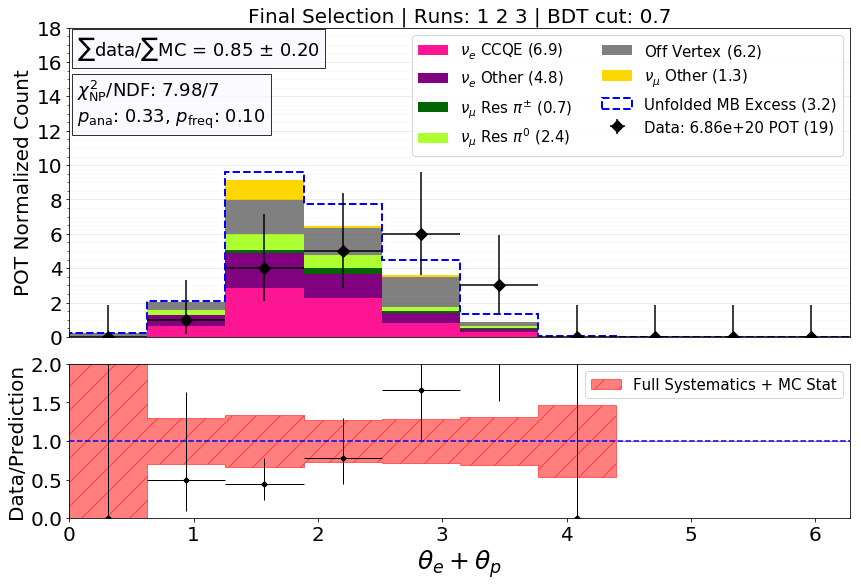

[[ 0.07105497  0.04621357  0.03392735  0.01040774 -0.00403725 -0.01008278
  -0.01169893 -0.01034001  0.0054267   0.0511401 ]
 [ 0.04621357  0.0606343   0.03747437  0.00503235 -0.00967638 -0.01551714
  -0.01720792 -0.01652206 -0.00850102  0.01098926]
 [ 0.03392735  0.03747437  0.02759491  0.0075101  -0.00485816 -0.01000931
  -0.01205869 -0.01255775 -0.00434509  0.01334169]
 [ 0.01040774  0.00503235  0.0075101   0.00559266  0.00161861 -0.00040469
  -0.00170718 -0.0028248   0.00010387  0.00815855]
 [-0.00403725 -0.00967638 -0.00485816  0.00161861  0.00528412  0.00642206
   0.00636121  0.00593441  0.00244767 -0.00170882]
 [-0.01008278 -0.01551714 -0.01000931 -0.00040469  0.00642206  0.00897951
   0.00953678  0.00952844  0.00345282 -0.00660568]
 [-0.01169893 -0.01720792 -0.01205869 -0.00170718  0.00636121  0.00953678
   0.01048462  0.01086999  0.00412587 -0.00752567]
 [-0.01034001 -0.01652206 -0.01255775 -0.0028248   0.00593441  0.00952844
   0.01086999  0.01184444  0.0051501  -0.00637487]


<Figure size 432x288 with 0 Axes>

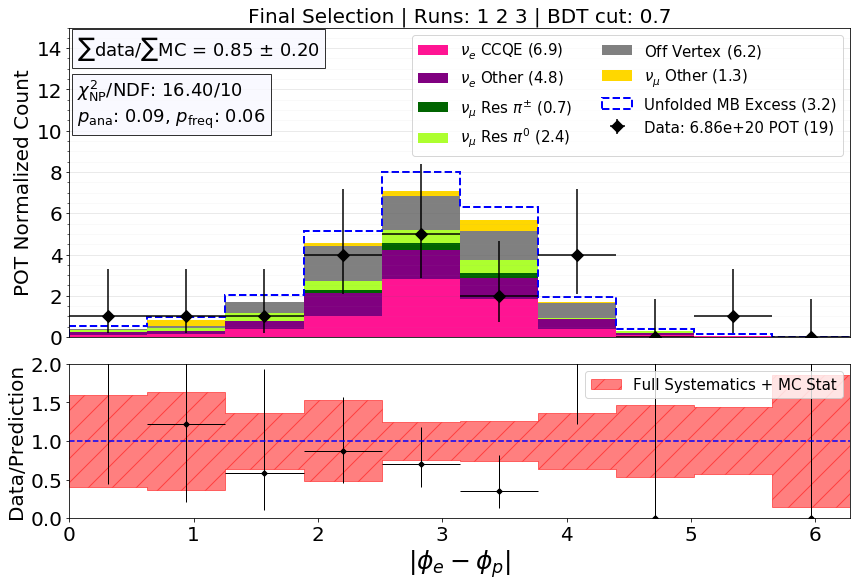

[[ 0.01887546  0.01324849  0.00872094  0.00321685 -0.00989441 -0.01546938
  -0.01062543  0.00440375  0.03038248  0.05211389]
 [ 0.01324849  0.01157297  0.0087816   0.00400125 -0.0057374  -0.00919287
  -0.00621468  0.00191326  0.01704544  0.03046504]
 [ 0.00872094  0.0087816   0.00731251  0.00388603 -0.00277007 -0.00502801
  -0.00316474  0.00115636  0.01031576  0.01920884]
 [ 0.00321685  0.00400125  0.00388603  0.00298426  0.00063132 -0.0003357
   0.00059193  0.00086125  0.00462412  0.00932562]
 [-0.00989441 -0.0057374  -0.00277007  0.00063132  0.00881155  0.0135646
   0.01238692  0.00180717 -0.01207928 -0.02156139]
 [-0.01546938 -0.00919287 -0.00502801 -0.0003357   0.0135646   0.02384163
   0.02317126  0.00647733 -0.01790432 -0.03579161]
 [-0.01062543 -0.00621468 -0.00316474  0.00059193  0.01238692  0.02317126
   0.02659011  0.01462043 -0.00212879 -0.01391556]
 [ 0.00440375  0.00191326  0.00115636  0.00086125  0.00180717  0.00647733
   0.01462043  0.02123319  0.03039152  0.03838694]
 [

<Figure size 432x288 with 0 Axes>

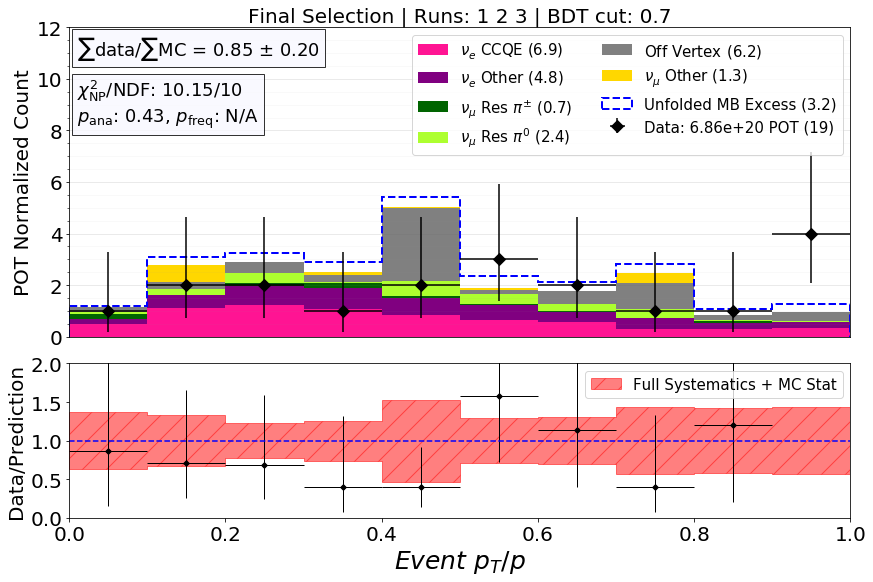

[[ 4.01459582e-03  4.93806906e-03  3.85428081e-03  2.16430522e-03
   9.92956908e-05 -1.79202296e-03  4.44514957e-03  3.55929140e-02
   9.55871220e-02  0.00000000e+00]
 [ 4.93806906e-03  8.51576554e-03  7.86203363e-03  4.87249284e-03
   9.99635907e-04 -2.19934546e-03  9.91841672e-03  8.49108342e-02
   3.09834029e-01  0.00000000e+00]
 [ 3.85428081e-03  7.86203363e-03  8.06755662e-03  5.76323937e-03
   2.34126024e-03 -8.72046068e-04  8.81087155e-03  7.67907107e-02
   2.92356079e-01  0.00000000e+00]
 [ 2.16430522e-03  4.87249284e-03  5.76323937e-03  5.33616233e-03
   3.84060133e-03  1.60699007e-03  5.23843931e-03  3.40276174e-02
   1.16378839e-01  0.00000000e+00]
 [ 9.92956908e-05  9.99635907e-04  2.34126024e-03  3.84060133e-03
   4.87419358e-03  5.02442356e-03  4.13769858e-03 -4.93546727e-03
  -4.10755521e-02  0.00000000e+00]
 [-1.79202296e-03 -2.19934546e-03 -8.72046068e-04  1.60699007e-03
   5.02442356e-03  1.04854454e-02  1.39055269e-02 -8.89041452e-04
  -2.32976107e-02  0.00000000e+00

<Figure size 432x288 with 0 Axes>

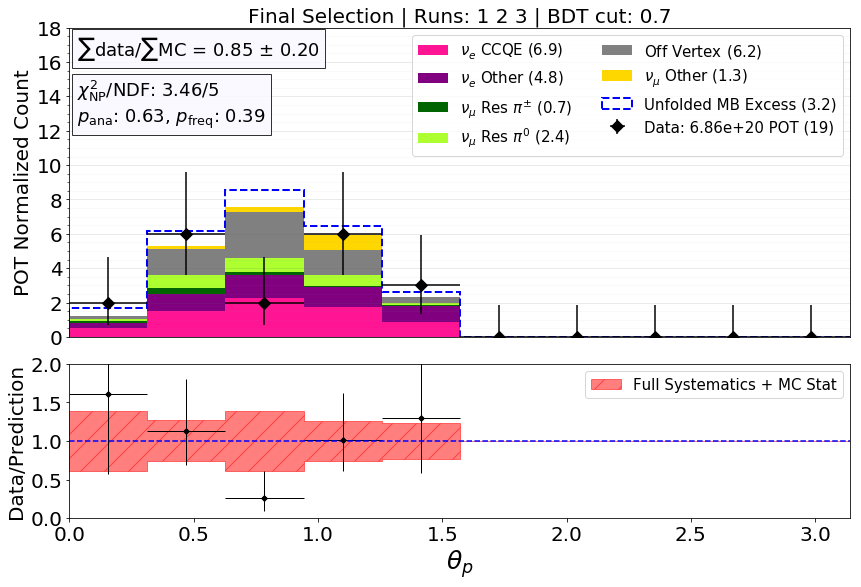

[[ 0.06493636  0.04434495 -0.01237949 -0.04803778 -0.04642143 -0.02657522
  -0.00578264 -0.00216438 -0.00530409 -0.02140655]
 [ 0.04434495  0.03622674  0.00204382 -0.0229045  -0.02617842 -0.0182468
  -0.00791225 -0.0058054  -0.00619109 -0.01286204]
 [-0.01237949  0.00204382  0.02858354  0.04054184  0.03140054  0.01134646
  -0.00640519 -0.00945799 -0.00509075  0.01093248]
 [-0.04803778 -0.0229045   0.04054184  0.07790588  0.06799076  0.03266762
  -0.001901   -0.00894114 -0.00248732  0.02696804]
 [-0.04642143 -0.02617842  0.03140054  0.06799076  0.06220172  0.03291137
   0.00258446 -0.00474976 -0.0004806   0.02435362]
 [-0.02657522 -0.0182468   0.01134646  0.03266762  0.03291137  0.02074263
   0.00619105  0.00105267  0.00123831  0.01188   ]
 [-0.00578264 -0.00791225 -0.00640519 -0.001901    0.00258446  0.00619105
   0.00742489  0.00546357  0.00289149  0.00058931]
 [-0.00216438 -0.0058054  -0.00945799 -0.00894114 -0.00474976  0.00105267
   0.00546357  0.00541819  0.00358853 -0.00057806]
 

<Figure size 432x288 with 0 Axes>

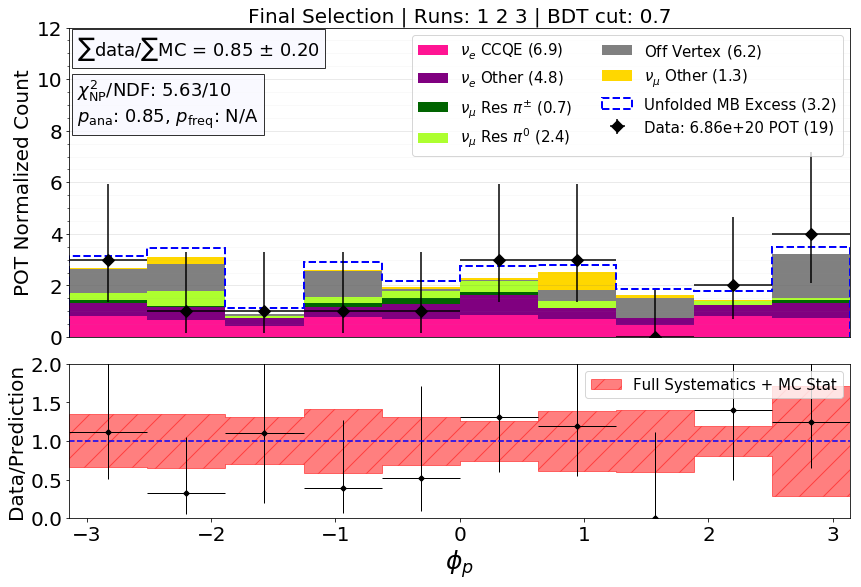

[[ 0.63244476  0.          0.         -0.03661752 -0.04008752 -0.04132514
  -0.04152716 -0.04151317 -0.0426158   0.263831  ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.03661752  0.          0.          0.00438766  0.0045602   0.00461997
   0.0046059   0.0045411   0.00408166 -0.03851367]
 [-0.04008752  0.          0.          0.0045602   0.00475744  0.00482601
   0.00481524  0.00475454  0.00433458 -0.03886124]
 [-0.04132514  0.          0.          0.00461997  0.00482601  0.00489826
   0.0048894   0.00483126  0.00443655 -0.03870971]
 [-0.04152716  0.          0.          0.0046059   0.00481524  0.0048894
   0.00488378  0.00483111  0.00448765 -0.03651581]
 [-0.04151317  0.          0.          0.0045411   0.00475454  0.00483126
   0.00483111  0.00478831  0.00453898 -0.03187843]
 [-0.0426158   0.

<Figure size 432x288 with 0 Axes>

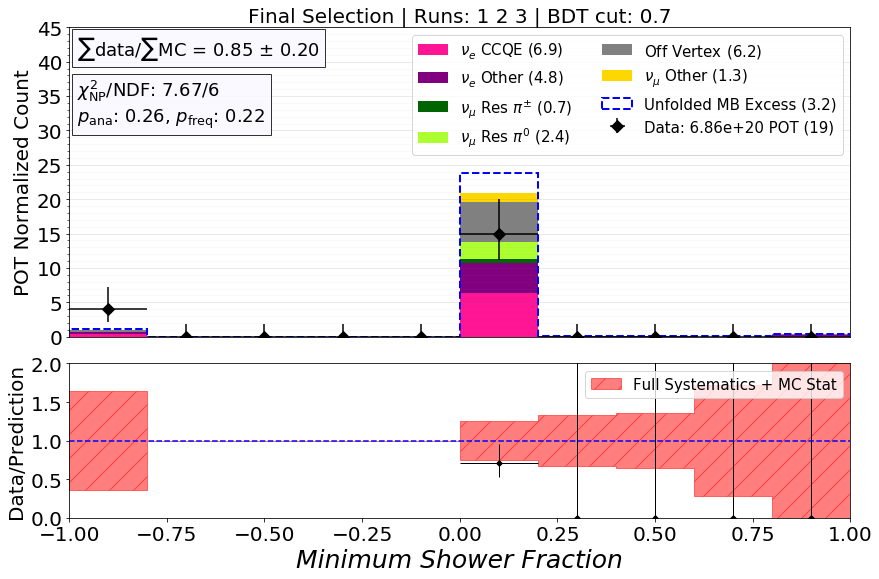

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.29198865e-03
  -1.64962752e-02  1.61092772e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.54367067e+03  4.63804883e+02
   9.46324400e+00 -1.58654765e+01

<Figure size 432x288 with 0 Axes>

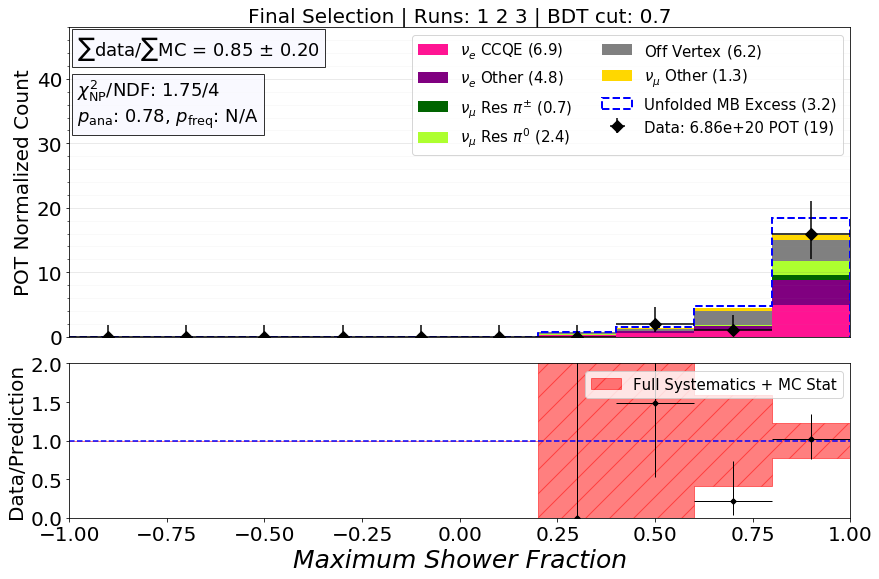

[[ 0.01338471  0.00878468  0.0056299   0.0029792   0.00145994 -0.00010973
  -0.00441058 -0.00941971 -0.01444641 -0.00699301]
 [ 0.00878468  0.00694649  0.00626269  0.00543738  0.00340394  0.00200306
  -0.00298344 -0.00800046 -0.00888467 -0.00799784]
 [ 0.0056299   0.00626269  0.00871967  0.01019069  0.0069627   0.00554933
  -0.00213877 -0.00871605 -0.00430094 -0.01125856]
 [ 0.0029792   0.00543738  0.01019069  0.01354872  0.00958039  0.00850584
  -0.00068466 -0.00830849  0.00019085 -0.01217486]
 [ 0.00145994  0.00340394  0.0069627   0.00958039  0.00695445  0.00656987
   0.00055422 -0.00462768  0.00132106 -0.00837961]
 [-0.00010973  0.00200306  0.00554933  0.00850584  0.00656987  0.00801033
   0.00514743  0.00191165  0.00891621 -0.00171042]
 [-0.00441058 -0.00298344 -0.00213877 -0.00068466  0.00055422  0.00514743
   0.01234004  0.0164465   0.02005427  0.01401554]
 [-0.00941971 -0.00800046 -0.00871605 -0.00830849 -0.00462768  0.00191165
   0.0164465   0.02712582  0.02971196  0.02789738]


<Figure size 432x288 with 0 Axes>

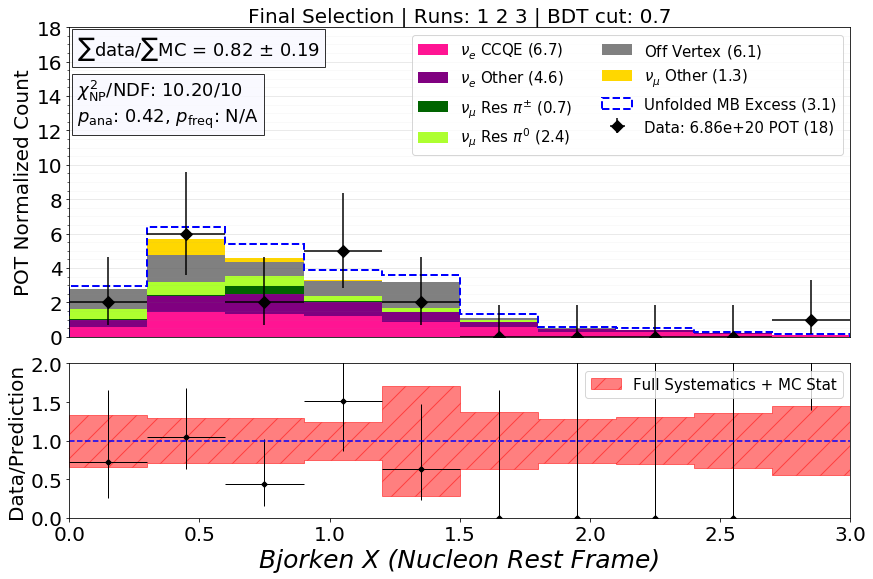

[[ 5.04674022e-03  4.41375156e-03  3.14477404e-03  2.01490861e-03
  -1.27563194e-04 -3.48670572e-04  9.24588991e-04  2.80629965e-03
   7.29016730e-03  1.59113713e-02]
 [ 4.41375156e-03  7.51036003e-03  8.24450161e-03  7.16625896e-03
   3.42393503e-03 -9.55140082e-04 -9.59794880e-04  3.67952665e-03
   1.28401655e-02  1.81400441e-02]
 [ 3.14477404e-03  8.24450161e-03  1.06511425e-02  1.01141344e-02
   6.35425582e-03 -2.45396195e-04 -1.85160359e-03  3.49231547e-03
   1.28983634e-02  1.37294611e-02]
 [ 2.01490861e-03  7.16625896e-03  1.01141344e-02  1.02150733e-02
   7.40736639e-03  6.58412921e-04 -1.92407141e-03  2.73567432e-03
   1.01549271e-02  6.43194537e-03]
 [-1.27563194e-04  3.42393503e-03  6.35425582e-03  7.40736639e-03
   7.21431039e-03  2.90343691e-03 -2.17420706e-04  1.58994300e-03
   2.22769585e-03 -6.75131073e-03]
 [-3.48670572e-04 -9.55140082e-04 -2.45396195e-04  6.58412921e-04
   2.90343691e-03  5.14816128e-03  4.14470160e-03  1.92807909e-03
  -6.06680190e-03 -1.00842674e-02

<Figure size 432x288 with 0 Axes>

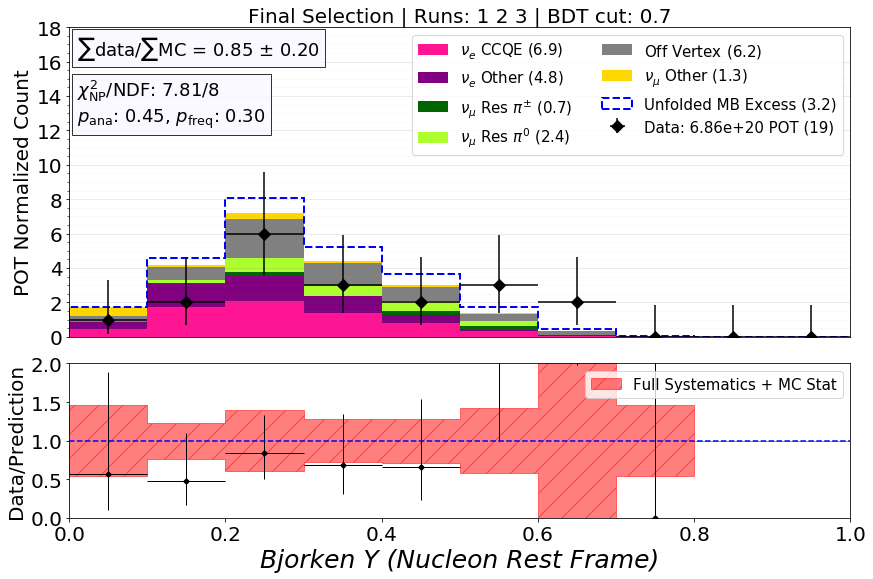

[[ 5.95491499e-03  5.40351659e-03  4.61677679e-03  2.76455266e-03
  -2.86032075e-04 -1.56885144e-03 -2.66089697e-03 -8.86472707e-03
  -9.07513736e-03  4.26566464e-03]
 [ 5.40351659e-03  7.08130466e-03  6.43173466e-03 -2.85373471e-03
  -1.25081251e-02 -1.10755440e-02 -4.96473275e-03 -6.09768935e-03
  -1.80994500e-02 -3.91836253e-02]
 [ 4.61677679e-03  6.43173466e-03  8.35256635e-03  3.54122895e-04
  -1.22441903e-02 -1.02977028e-02 -2.01436634e-03 -1.11879662e-02
  -2.38071952e-02 -4.31400244e-02]
 [ 2.76455266e-03 -2.85373471e-03  3.54122895e-04  3.20296910e-02
   5.05815539e-02  4.55593928e-02  2.62535863e-02 -1.67546622e-02
   2.90357426e-02  2.05111785e-01]
 [-2.86032075e-04 -1.25081251e-02 -1.22441903e-02  5.05815539e-02
   1.03254857e-01  9.28796921e-02  4.65335818e-02 -4.49726075e-03
   9.21569376e-02  4.10094965e-01]
 [-1.56885144e-03 -1.10755440e-02 -1.02977028e-02  4.55593928e-02
   9.28796921e-02  8.97804818e-02  5.00501332e-02 -8.13157856e-04
   8.45847768e-02  3.73736147e-01

<Figure size 432x288 with 0 Axes>

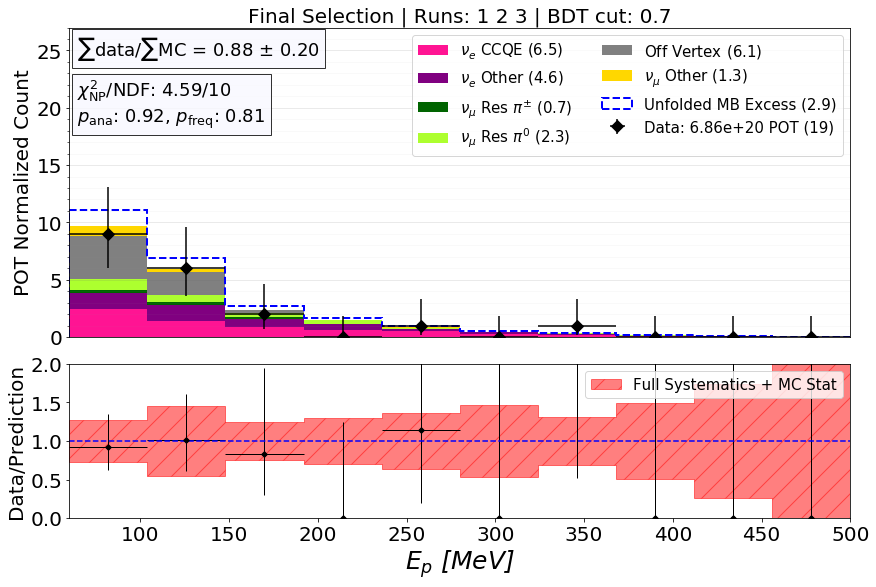

[[ 2.91118402e-02  2.45280694e-02  1.86816971e-02  1.26522738e-02
   5.97061580e-03  5.57228013e-03  4.11608343e-03 -1.78105266e-02
  -3.56680776e-02  3.35974892e-03]
 [ 2.45280694e-02  2.13424783e-02  1.62814995e-02  9.84553531e-03
   4.17649618e-03  5.30699565e-03  4.06105414e-03 -1.56062653e-02
  -3.24027886e-02 -3.36708089e-03]
 [ 1.86816971e-02  1.62814995e-02  1.26551834e-02  7.94301316e-03
   3.24416033e-03  4.45901644e-03  4.48187595e-03 -1.15096149e-02
  -2.61131163e-02 -4.61659510e-03]
 [ 1.26522738e-02  9.84553531e-03  7.94301316e-03  9.05660479e-03
   6.21454056e-03  6.86716773e-04  1.47337132e-04 -6.21332204e-03
  -1.23129387e-02  1.06683817e-02]
 [ 5.97061580e-03  4.17649618e-03  3.24416033e-03  6.21454056e-03
   7.33176733e-03  2.01791966e-03 -3.66993950e-04 -8.40819349e-04
  -6.94956736e-04  1.81935875e-02]
 [ 5.57228013e-03  5.30699565e-03  4.45901644e-03  6.86716773e-04
   2.01791966e-03  2.52759315e-02  3.88911331e-02  4.15450835e-03
  -3.57901420e-02 -2.22745840e-02

<Figure size 432x288 with 0 Axes>

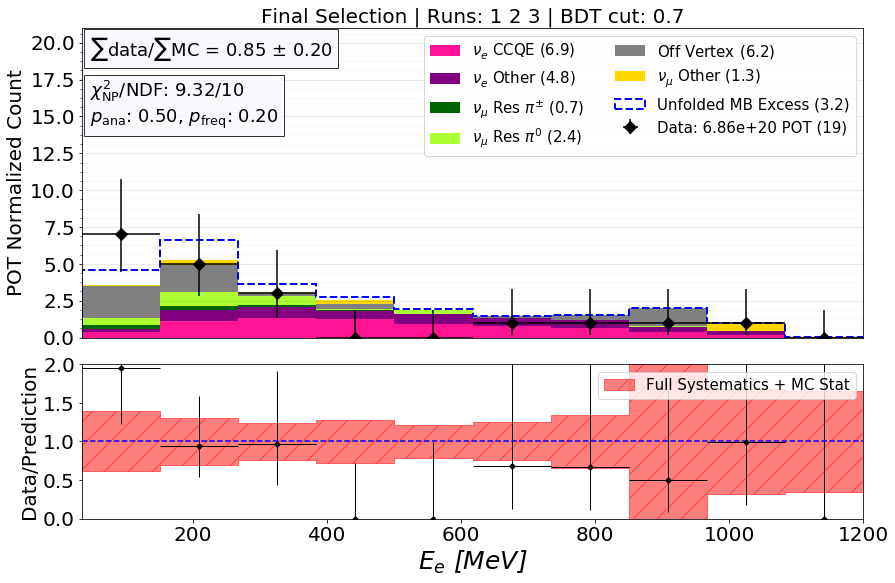

[[ 0.00659332  0.00418067  0.00099581 -0.00080563 -0.00143261  0.00059184
   0.00337384  0.00433516  0.00445072  0.00295098]
 [ 0.00418067  0.00438939  0.00354148  0.00282848  0.00122952  0.00250633
   0.00492481  0.00770037  0.0073866   0.00305511]
 [ 0.00099581  0.00354148  0.00522263  0.00604116  0.00407436  0.00431616
   0.00540666  0.00914882  0.00858506  0.0025633 ]
 [-0.00080563  0.00282848  0.00604116  0.00860145  0.00704072  0.00649415
   0.00605359  0.00957396  0.00938584  0.00373903]
 [-0.00143261  0.00122952  0.00407436  0.00704072  0.00685159  0.00621314
   0.00499288  0.00663176  0.00675849  0.00399983]
 [ 0.00059184  0.00250633  0.00431616  0.00649415  0.00621314  0.00684825
   0.00703777  0.00931722  0.00933916  0.00594994]
 [ 0.00337384  0.00492481  0.00540666  0.00605359  0.00499288  0.00703777
   0.01027416  0.01432545  0.01375945  0.00811184]
 [ 0.00433516  0.00770037  0.00914882  0.00957396  0.00663176  0.00931722
   0.01432545  0.02233632  0.0210983   0.0098006 ]


<Figure size 432x288 with 0 Axes>

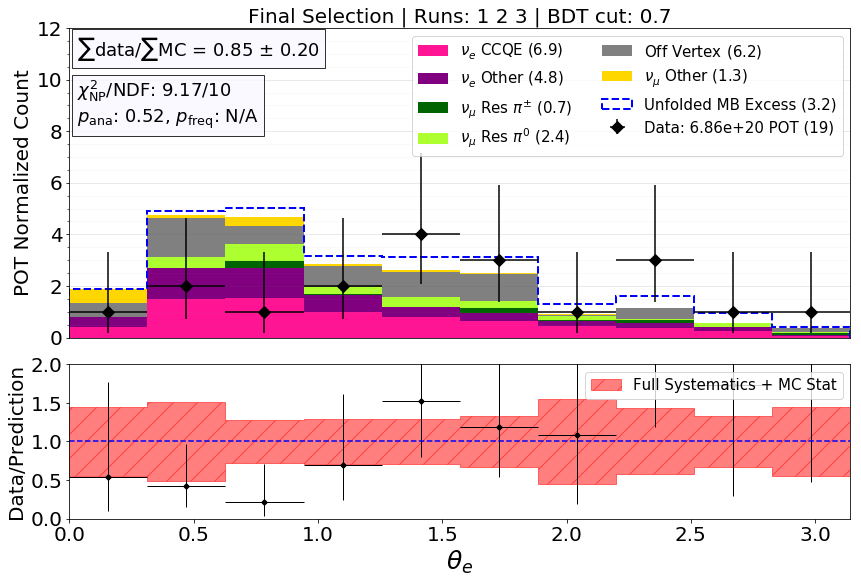

[[ 3.21005557e-02  4.25454786e-02  3.51915895e-02  1.25503418e-02
   5.74378715e-05 -6.96015886e-03 -1.07546305e-02 -1.42175004e-02
  -1.26705915e-02  2.66265280e-03]
 [ 4.25454786e-02  7.30688610e-02  7.30854074e-02  3.20867151e-02
   5.17762725e-03 -1.08322132e-02 -1.91363808e-02 -2.20951029e-02
  -1.62658267e-02  1.83360156e-02]
 [ 3.51915895e-02  7.30854074e-02  8.54278956e-02  4.48193605e-02
   1.34600146e-02 -7.12744772e-03 -1.98670324e-02 -2.27590332e-02
  -1.45952572e-02  2.69458481e-02]
 [ 1.25503418e-02  3.20867151e-02  4.48193605e-02  3.02155275e-02
   1.47457447e-02  2.65126663e-03 -6.71322049e-03 -1.06246805e-02
  -7.36768399e-03  1.63176092e-02]
 [ 5.74378715e-05  5.17762725e-03  1.34600146e-02  1.47457447e-02
   1.15823211e-02  7.21338636e-03  2.50615957e-03 -9.80284135e-04
  -1.35835412e-03  7.92143789e-03]
 [-6.96015886e-03 -1.08322132e-02 -7.12744772e-03  2.65126663e-03
   7.21338636e-03  8.57222629e-03  8.03712002e-03  5.58189152e-03
   3.14003542e-03  3.12936558e-03

<Figure size 432x288 with 0 Axes>

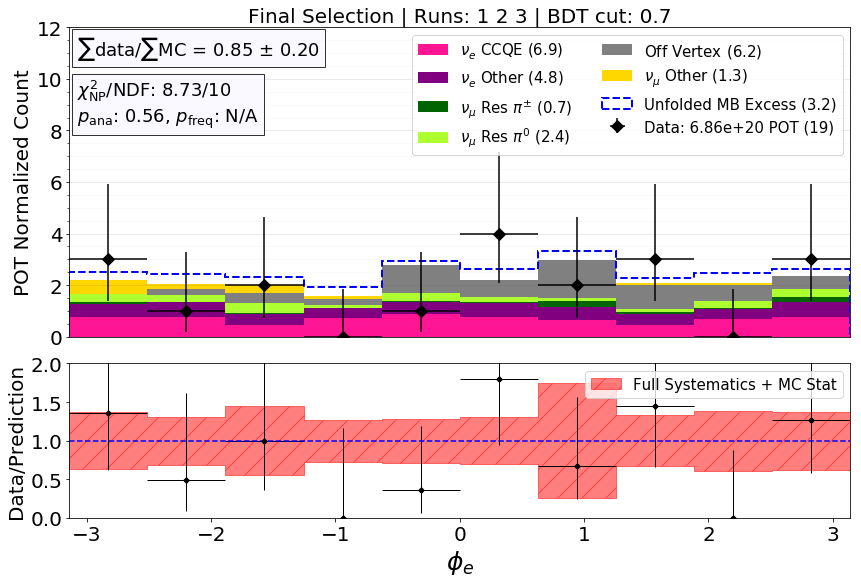

[[ 2.71111333e+00  1.09921097e+00  3.19194788e-01  1.01828898e-01
  -6.51160656e-03 -4.79681548e-02 -4.38218987e-02 -5.16878947e-02
  -5.77984426e-02 -6.35897098e-02]
 [ 1.09921097e+00  5.99582906e-01  2.43048634e-01  9.10577069e-02
   8.86793560e-03 -2.52485263e-02 -3.30706541e-02 -4.45231005e-02
  -5.57834072e-02 -6.59295732e-02]
 [ 3.19194788e-01  2.43048634e-01  1.43388126e-01  6.34888708e-02
   1.21179971e-02 -1.15661522e-02 -2.18973731e-02 -3.15788556e-02
  -3.94254926e-02 -4.59571244e-02]
 [ 1.01828898e-01  9.10577069e-02  6.34888708e-02  3.14774226e-02
   7.36752972e-03 -4.29423115e-03 -1.00254083e-02 -1.54795047e-02
  -1.94247105e-02 -2.27872694e-02]
 [-6.51160656e-03  8.86793560e-03  1.21179971e-02  7.36752972e-03
   3.48622711e-03  1.29797333e-03 -2.80301344e-04 -1.59226222e-03
  -2.50324866e-03 -2.78172249e-03]
 [-4.79681548e-02 -2.52485263e-02 -1.15661522e-02 -4.29423115e-03
   1.29797333e-03  4.14155307e-03  4.74667048e-03  5.54790621e-03
   5.93307325e-03  6.38269425e-03

<Figure size 432x288 with 0 Axes>

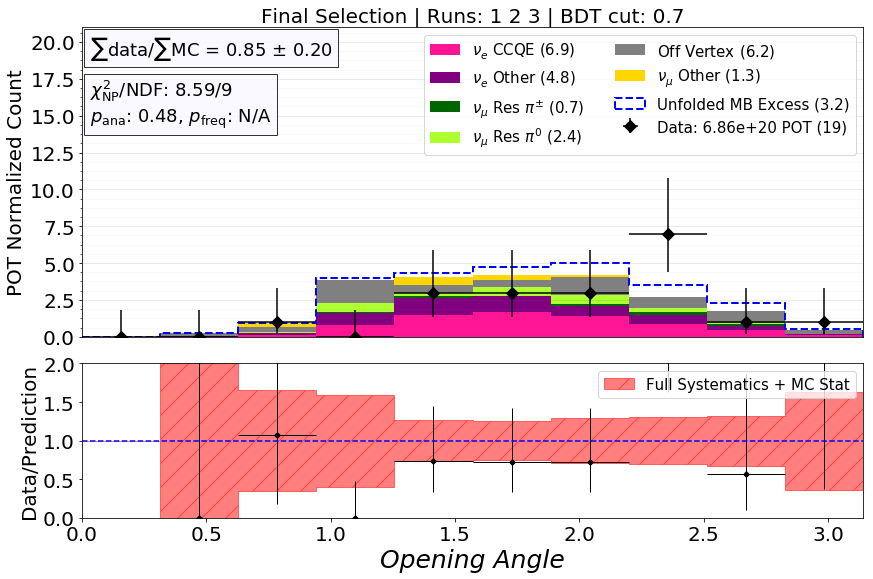

[[ 3.24003552e-02  1.20493207e-02  5.56508651e-03  6.11998970e-03
   2.69026882e-03 -3.96849933e-03 -6.05277158e-04  9.80850919e-03
   7.38132240e-04 -2.86859281e-02]
 [ 1.20493207e-02  6.41321910e-03  4.07489046e-03  4.36597085e-03
   2.90776994e-03 -1.38381634e-03 -2.98016381e-03  1.56417101e-03
   1.48696060e-03 -7.48025547e-03]
 [ 5.56508651e-03  4.07489046e-03  3.66503106e-03  4.78875339e-03
   4.01182165e-03 -1.69099282e-04 -4.88927691e-03 -2.87506945e-03
   8.82920739e-05 -2.76789944e-03]
 [ 6.11998970e-03  4.36597085e-03  4.78875339e-03  9.01977017e-03
   8.17196973e-03  1.64185617e-03 -4.07181065e-03 -1.42592411e-03
  -8.48798629e-04 -1.04115092e-02]
 [ 2.69026882e-03  2.90776994e-03  4.01182165e-03  8.17196973e-03
   8.58029299e-03  4.66936165e-03 -8.59834538e-04 -6.52547637e-04
  -9.23012297e-04 -9.92430626e-03]
 [-3.96849933e-03 -1.38381634e-03 -1.69099282e-04  1.64185617e-03
   4.66936165e-03  1.16071870e-02  1.45476361e-02  1.06203303e-02
   3.11617067e-03 -9.81948259e-03

<Figure size 432x288 with 0 Axes>

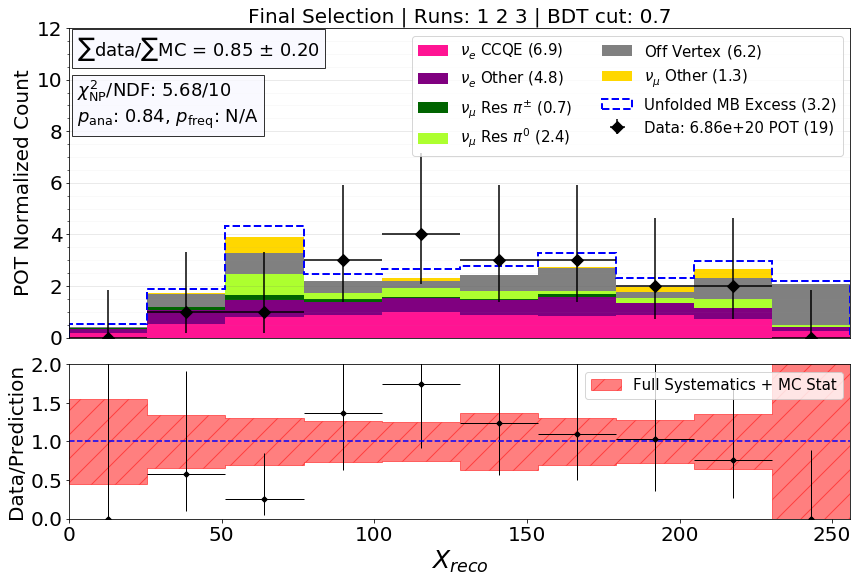

[[ 0.0411501   0.03388836  0.01805204 -0.002753   -0.0048312   0.01137342
   0.01997032  0.01182991 -0.0023009  -0.01234309]
 [ 0.03388836  0.03291883  0.01994771 -0.00173081 -0.00854774  0.00201935
   0.01014495  0.00807334  0.00108375 -0.00584687]
 [ 0.01805204  0.01994771  0.01403707  0.0001611  -0.00640295 -0.00146193
   0.00381124  0.00406945  0.00152773 -0.00131503]
 [-0.002753   -0.00173081  0.0001611   0.00340807  0.00208952 -0.00215549
  -0.00260364 -0.00141345  0.00018968  0.00305533]
 [-0.0048312  -0.00854774 -0.00640295  0.00208952  0.00976119  0.00965992
   0.00724349  0.00293587 -0.00264096 -0.00156432]
 [ 0.01137342  0.00201935 -0.00146193 -0.00215549  0.00965992  0.02533715
   0.02612016  0.01068398 -0.00860877 -0.01495448]
 [ 0.01997032  0.01014495  0.00381124 -0.00260364  0.00724349  0.02612016
   0.02952717  0.01390038 -0.00726819 -0.01533515]
 [ 0.01182991  0.00807334  0.00406945 -0.00141345  0.00293587  0.01068398
   0.01390038  0.01159943  0.00375064  0.00062353]


<Figure size 432x288 with 0 Axes>

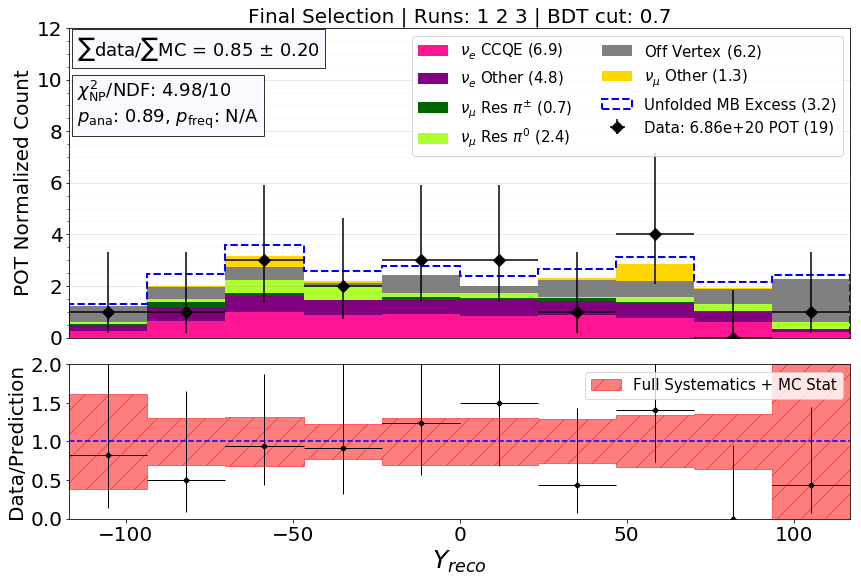

[[ 0.04797805  0.02617202 -0.00522833 -0.00835971  0.02235072  0.03349334
   0.00110643 -0.02226863 -0.01564092 -0.00826319]
 [ 0.02617202  0.01902232  0.00207352  0.00043313  0.02015986  0.02699535
   0.00603277 -0.01235211 -0.01246275 -0.0086823 ]
 [-0.00522833  0.00207352  0.01091017  0.00865903 -0.00233483 -0.00742469
   0.00037389  0.0041216  -0.00175947 -0.00492319]
 [-0.00835971  0.00043313  0.00865903  0.00971916  0.00291192 -0.00208283
   0.00278288  0.0037356  -0.00196883 -0.00397414]
 [ 0.02235072  0.02015986 -0.00233483  0.00291192  0.04473781  0.06088902
   0.02264954 -0.0156094  -0.01755176 -0.01012462]
 [ 0.03349334  0.02699535 -0.00742469 -0.00208283  0.06088902  0.09197793
   0.03808723 -0.02020866 -0.02242621 -0.01181442]
 [ 0.00110643  0.00603277  0.00037389  0.00278288  0.02264954  0.03808723
   0.02744032  0.00383371 -0.00420683 -0.00307468]
 [-0.02226863 -0.01235211  0.0041216   0.0037356  -0.0156094  -0.02020866
   0.00383371  0.01901102  0.01167396  0.00526679]


<Figure size 432x288 with 0 Axes>

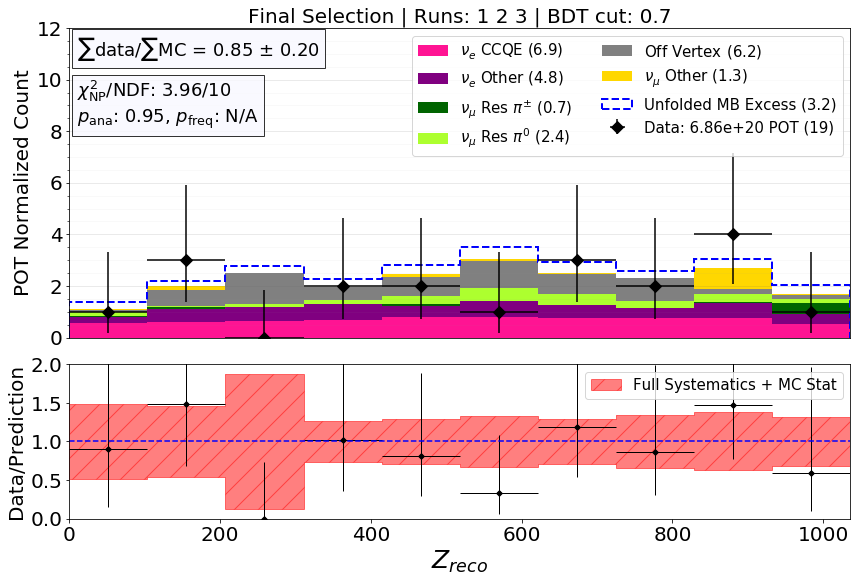

[[ 6.09734911e-03  2.63752008e-03  1.06222369e-03  2.34000276e-04
   4.23265719e-04  2.14433215e-03  1.76851607e-03 -7.36303638e-04
  -1.58231758e-03 -5.45098552e-04]
 [ 2.63752008e-03  7.21721451e-03  6.59929541e-03  3.02245293e-03
  -8.42883538e-04 -4.29611797e-03 -6.55408026e-03 -4.44351459e-03
   1.64043892e-04  1.97570566e-03]
 [ 1.06222369e-03  6.59929541e-03  1.16666678e-02  1.23112291e-02
   8.75845913e-03  3.16522795e-03 -3.95029909e-04 -1.17240770e-03
  -1.05303126e-04  1.27532650e-04]
 [ 2.34000276e-04  3.02245293e-03  1.23112291e-02  1.89476716e-02
   1.93788332e-02  1.68747626e-02  1.45483899e-02  6.75502664e-03
   8.89017688e-05 -2.50843728e-03]
 [ 4.23265719e-04 -8.42883538e-04  8.75845913e-03  1.93788332e-02
   2.52262965e-02  2.96026540e-02  3.01341030e-02  1.43543247e-02
  -3.57566155e-04 -5.48217174e-03]
 [ 2.14433215e-03 -4.29611797e-03  3.16522795e-03  1.68747626e-02
   2.96026540e-02  4.48667624e-02  4.96512903e-02  2.36497758e-02
  -1.30565250e-04 -7.88673670e-03

<Figure size 432x288 with 0 Axes>

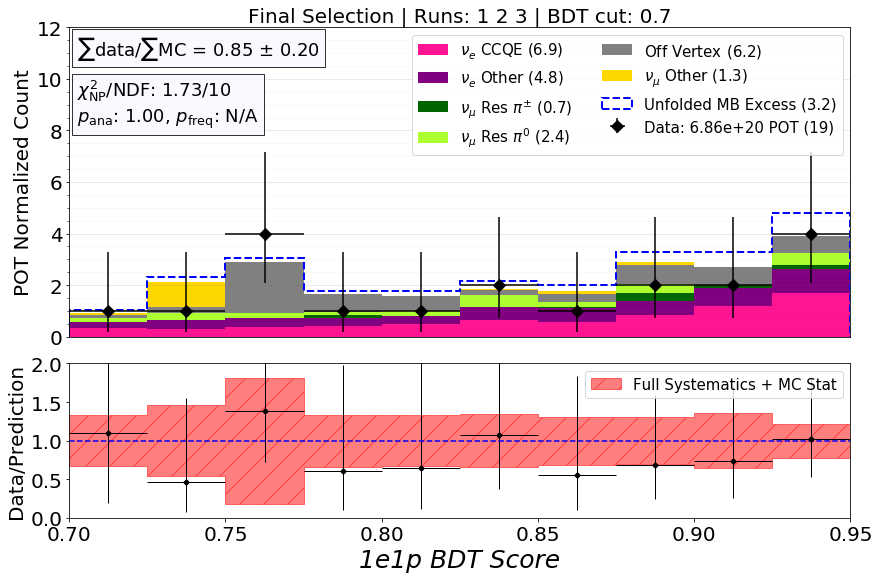

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04]]
[10.27076154  1.43581021  0.          0.          0.          0.
  0.          0.          0.          0.        ]
[9.64836779 0.63904762 

/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:568: RuntimeWarning: divide by zero encountered in double_scalars


<Figure size 432x288 with 0 Axes>

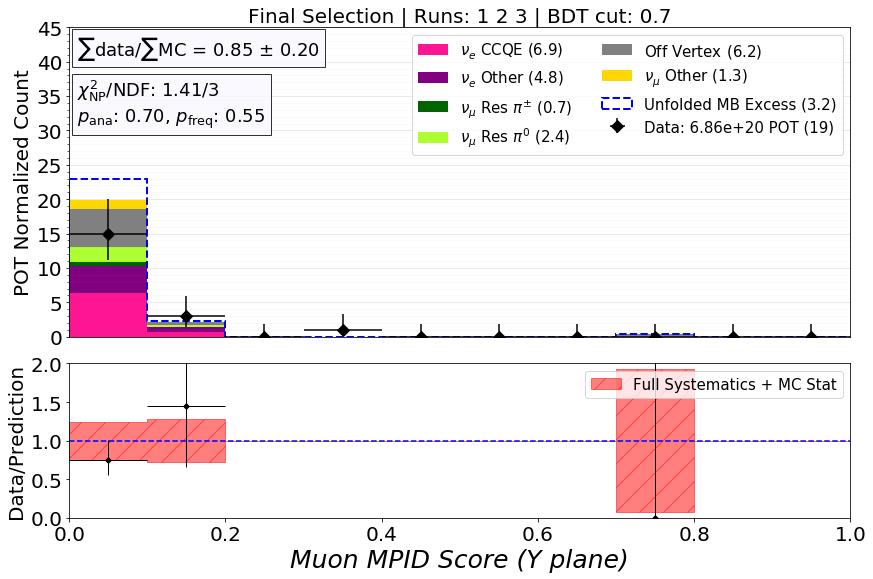

[[ 5.34411457e-02  5.80922282e-02  8.64906799e-02  9.73549638e-02
   2.09681377e-02 -1.12103033e-02 -3.88835901e-02 -4.31346673e-02
  -1.60138042e-02 -4.06445993e-04]
 [ 5.80922282e-02  1.18960188e-01  1.65494349e-01  1.28961731e-01
  -6.31372499e-03 -6.58286268e-02 -7.56735948e-02 -6.17266967e-02
  -1.68047162e-02  1.21108220e-02]
 [ 8.64906799e-02  1.65494349e-01  5.44941382e-01  7.16784660e-01
   3.01024493e-01  2.55541621e-02 -2.04577801e-01 -2.43363606e-01
  -1.19293263e-01 -6.64300785e-02]
 [ 9.73549638e-02  1.28961731e-01  7.16784660e-01  1.09985793e+00
   5.58815463e-01  1.58340842e-01 -2.55787060e-01 -3.58767983e-01
  -1.86780377e-01 -1.29547319e-01]
 [ 2.09681377e-02 -6.31372499e-03  3.01024493e-01  5.58815463e-01
   3.56136225e-01  1.70533686e-01 -7.96535382e-02 -1.72248239e-01
  -1.16866514e-01 -1.01879038e-01]
 [-1.12103033e-02 -6.58286268e-02  2.55541621e-02  1.58340842e-01
   1.70533686e-01  1.50768909e-01  4.31669786e-02 -2.90101861e-02
  -5.53359526e-02 -7.28014051e-02

<Figure size 432x288 with 0 Axes>

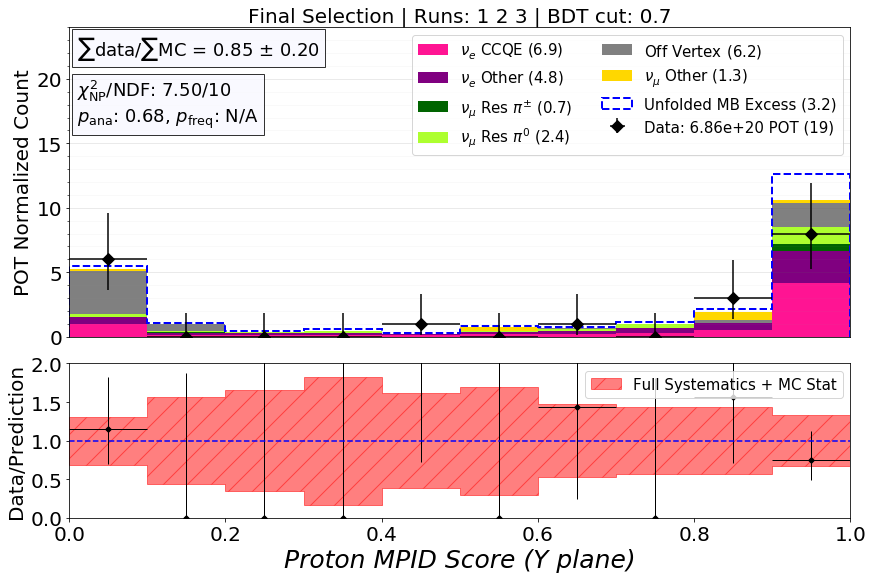

[[ 0.08091754  0.13842331  0.09984212  0.06034945  0.04024969  0.02223849
  -0.00707889 -0.04160172 -0.05488313 -0.04189755]
 [ 0.13842331  0.59034018  0.52276356  0.36380308  0.30474312  0.22603947
   0.03494735 -0.16741536 -0.23024412 -0.18605842]
 [ 0.09984212  0.52276356  0.55345882  0.41444877  0.3148144   0.1940615
   0.01838862 -0.165949   -0.23171339 -0.18981639]
 [ 0.06034945  0.36380308  0.41444877  0.32763667  0.25560757  0.157375
   0.02195129 -0.12192785 -0.17240857 -0.14059113]
 [ 0.04024969  0.30474312  0.3148144   0.25560757  0.28374549  0.2821398
   0.10912495 -0.08236287 -0.14499988 -0.13477693]
 [ 0.02223849  0.22603947  0.1940615   0.157375    0.2821398   0.40554242
   0.20614838 -0.03092434 -0.11904586 -0.14519223]
 [-0.00707889  0.03494735  0.01838862  0.02195129  0.10912495  0.20614838
   0.12214319  0.01352961 -0.03226608 -0.05976   ]
 [-0.04160172 -0.16741536 -0.165949   -0.12192785 -0.08236287 -0.03092434
   0.01352961  0.05781258  0.06925315  0.04743062]
 [-0

<Figure size 432x288 with 0 Axes>

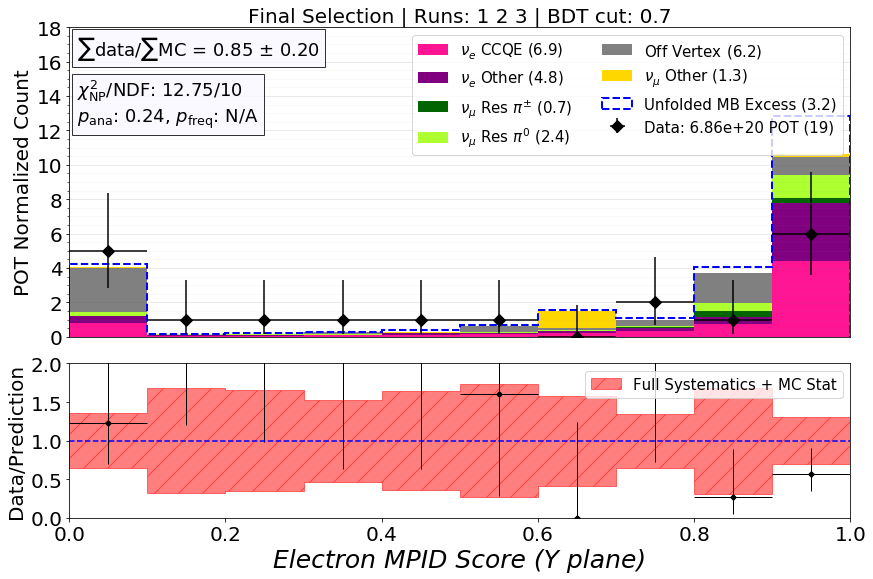

[[ 3.16538858e-02  8.78674362e-03  2.36369288e-03 -7.65543705e-04
  -4.10415848e-03 -7.77888276e-03 -1.68258589e-02 -2.54904408e-02
   7.08159402e-02  1.67325203e-01]
 [ 8.78674362e-03  3.06035262e-03  6.25940089e-04 -4.98372332e-04
  -1.63310071e-03 -3.06038183e-03 -5.27650444e-03 -5.61828243e-03
   2.21230409e-02  4.41519266e-02]
 [ 2.36369288e-03  6.25940089e-04  1.78381821e-03  2.23967997e-03
   2.70413628e-03  3.67612855e-03  4.45106893e-03  7.88557885e-03
   1.51661420e-02  2.30722957e-02]
 [-7.65543705e-04 -4.98372332e-04  2.23967997e-03  3.50367336e-03
   4.74402408e-03  6.96833712e-03  9.96976999e-03  1.63035323e-02
   1.73719585e-02  2.07694937e-02]
 [-4.10415848e-03 -1.63310071e-03  2.70413628e-03  4.74402408e-03
   6.77573027e-03  1.02193433e-02  1.54165639e-02  2.53616986e-02
   1.80700859e-02  1.47405381e-02]
 [-7.77888276e-03 -3.06038183e-03  3.67612855e-03  6.96833712e-03
   1.02193433e-02  1.57477272e-02  2.48748100e-02  4.13736747e-02
   2.94948366e-02  2.37631986e-02

<Figure size 432x288 with 0 Axes>

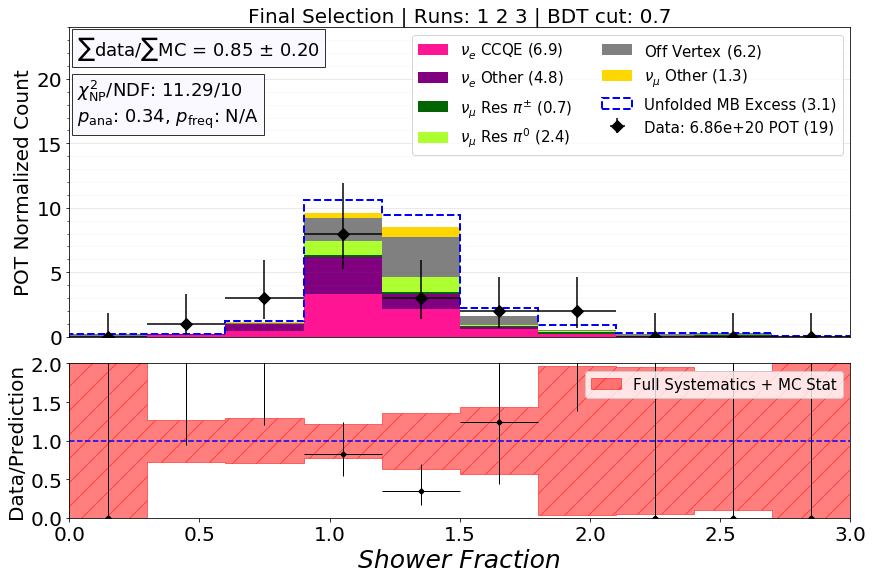

[[ 6.37046848e-03  5.04040290e-03  7.47443834e-04  1.11578901e-03
   1.43484177e-02  3.02547161e-02  3.07776416e-02 -1.04525609e-03
   0.00000000e+00  0.00000000e+00]
 [ 5.04040290e-03  5.45433094e-03  1.53356503e-03  1.54874964e-03
   1.48895905e-02  3.03726643e-02  4.13112842e-02 -1.10387668e-03
   0.00000000e+00  0.00000000e+00]
 [ 7.47443834e-04  1.53356503e-03  1.95758890e-03  5.62633425e-04
  -1.74412643e-03 -1.42010169e-03 -1.01618465e-02  2.00994833e-04
   0.00000000e+00  0.00000000e+00]
 [ 1.11578901e-03  1.54874964e-03  5.62633425e-04  4.41878980e-03
   1.87915628e-02  2.96687603e-02  4.72414365e-02 -4.90386155e-04
   0.00000000e+00  0.00000000e+00]
 [ 1.43484177e-02  1.48895905e-02 -1.74412643e-03  1.87915628e-02
   1.27443979e-01  2.21410595e-01  3.80774961e-01 -6.70469145e-03
   0.00000000e+00  0.00000000e+00]
 [ 3.02547161e-02  3.03726643e-02 -1.42010169e-03  2.96687603e-02
   2.21410595e-01  4.22272601e-01  8.03155889e-01 -1.66237918e-02
   0.00000000e+00  0.00000000e+00

<Figure size 432x288 with 0 Axes>

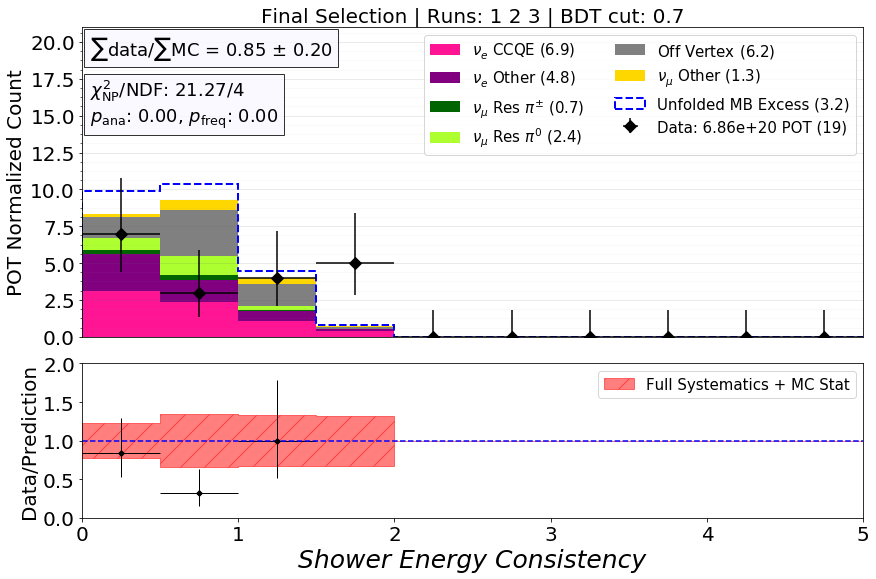

[[ 0.06477109  0.04471605  0.0351547   0.03967106  0.04053826  0.03104688
   0.01688311  0.0053593  -0.00566835 -0.01042155 -0.00936283 -0.01009641]
 [ 0.04471605  0.04294869  0.03367752  0.03631334  0.03393546  0.02476289
   0.01368414  0.00643879  0.00134363 -0.00113874 -0.00389105 -0.01273095]
 [ 0.0351547   0.03367752  0.02791045  0.02969423  0.02764886  0.01954554
   0.00929549  0.00049837 -0.00462861 -0.00496432 -0.00595694 -0.01364363]
 [ 0.03967106  0.03631334  0.02969423  0.03220236  0.03035375  0.0213025
   0.00957936  0.00078044 -0.00366996 -0.00458315 -0.00656213 -0.01478286]
 [ 0.04053826  0.03393546  0.02764886  0.03035375  0.02992588  0.02207873
   0.01056065  0.00086721 -0.00451092 -0.00519821 -0.00550866 -0.01200351]
 [ 0.03104688  0.02476289  0.01954554  0.0213025   0.02207873  0.01838432
   0.01157435  0.00378797 -0.00290878 -0.00370608 -0.00124084 -0.00367029]
 [ 0.01688311  0.01368414  0.00929549  0.00957936  0.01056065  0.01157435
   0.01209624  0.00944734  0.0028

<Figure size 432x288 with 0 Axes>

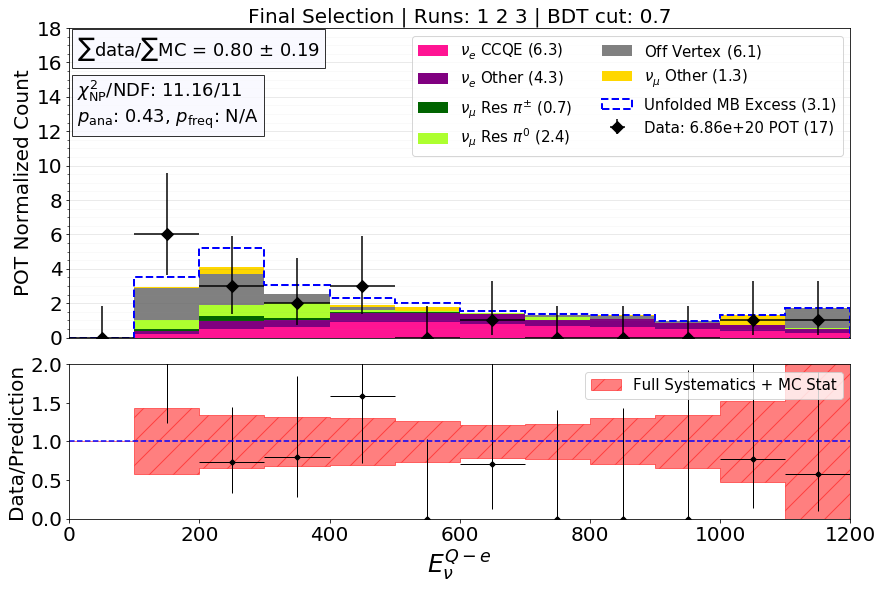

[[ 2.34395034e-01  2.59528063e-02  3.75216030e-02  4.65093473e-02
   2.67483579e-02  1.33900604e-03 -6.96545430e-03  7.92898570e-03
   3.76971799e-03 -1.90408663e-02  1.48333873e-02  1.21864150e-01]
 [ 2.59528063e-02  6.62104838e-02  2.66454694e-02  1.64114803e-02
   1.27961844e-02  1.58042653e-02  1.06781729e-02  3.45169795e-03
  -3.72480030e-03 -8.53600866e-03 -1.75856168e-02 -4.41894327e-02]
 [ 3.75216030e-02  2.66454694e-02  2.35408617e-02  2.11475434e-02
   1.30479620e-02  5.47370141e-03  1.27507943e-03  2.40297827e-03
   1.10115063e-03 -9.38671098e-04  7.81213852e-03  1.52734539e-02]
 [ 4.65093473e-02  1.64114803e-02  2.11475434e-02  2.45901786e-02
   1.79454590e-02  8.48221765e-03  2.98737944e-03  3.90572571e-03
   1.14323902e-03 -4.09993144e-03  1.07787925e-02  3.73237442e-02]
 [ 2.67483579e-02  1.27961844e-02  1.30479620e-02  1.79454590e-02
   1.64491344e-02  1.18116543e-02  6.98857395e-03  4.63681178e-03
   6.12773281e-05 -6.73659315e-03  2.11065302e-03  2.19567102e-02]
 [ 1.

<Figure size 432x288 with 0 Axes>

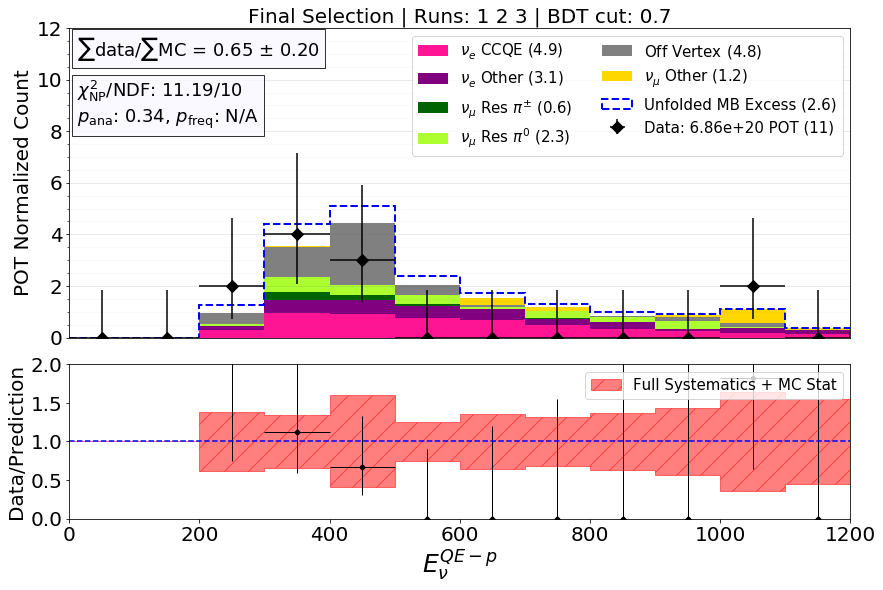

[[ 6.46479285e-03  6.20525584e-03  2.78060215e-03 -7.34740520e-03
  -1.14337546e-02 -1.09502302e-02 -6.57582915e-03 -3.03279049e-03
  -1.09758827e-02 -6.27701650e-02]
 [ 6.20525584e-03  6.61989127e-03  3.49289676e-03 -9.57515926e-03
  -1.50918952e-02 -1.09057257e-02 -4.69077517e-03 -4.46498463e-03
  -1.74404812e-02 -7.10125895e-02]
 [ 2.78060215e-03  3.49289676e-03  8.82129682e-03  1.12733932e-02
   5.04357828e-03  1.61742191e-02  8.49574229e-03 -2.39559659e-02
  -3.24341567e-02  5.54790078e-02]
 [-7.34740520e-03 -9.57515926e-03  1.12733932e-02  6.82857400e-02
   7.58226856e-02  8.04770612e-02  2.98019466e-02 -4.75410296e-02
  -1.29410501e-02  3.85824936e-01]
 [-1.14337546e-02 -1.50918952e-02  5.04357828e-03  7.58226856e-02
   9.73790010e-02  9.22885472e-02  2.89230189e-02 -4.03542086e-02
   7.79486275e-03  4.05317674e-01]
 [-1.09502302e-02 -1.09057257e-02  1.61742191e-02  8.04770612e-02
   9.22885472e-02  1.18567353e-01  5.01671509e-02 -6.59963112e-02
  -3.58195066e-02  4.79349758e-01

<Figure size 432x288 with 0 Axes>

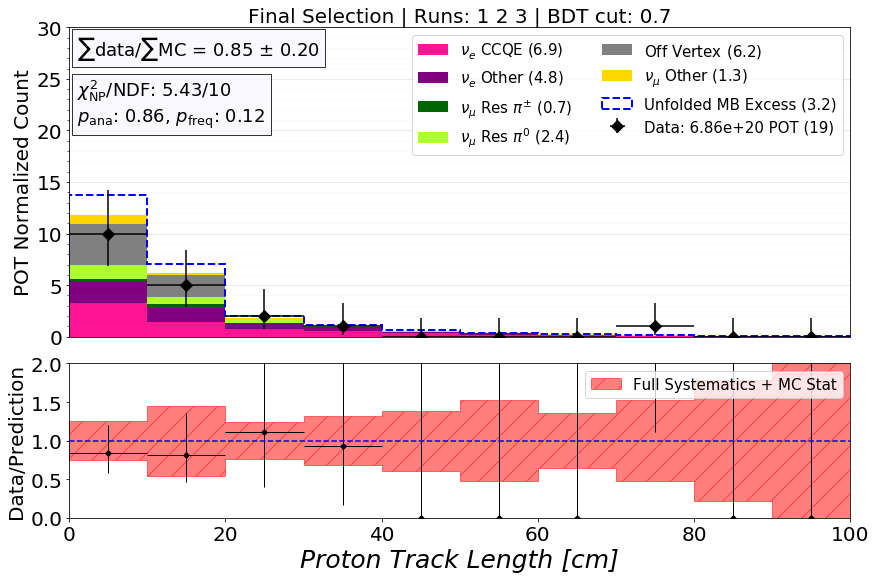

[[ 2.63551294e-02  1.61275690e-02  1.29715347e-02  1.08336837e-02
   3.84761519e-03 -4.15334389e-02 -8.54732840e-02 -2.32381958e-02
   2.92592433e-01  2.80247195e+00]
 [ 1.61275690e-02  1.26821456e-02  1.02410422e-02  5.68816930e-03
  -1.56519562e-03 -2.63246384e-02 -4.92339441e-02 -1.72310661e-02
   1.68732325e-01  1.23025286e+00]
 [ 1.29715347e-02  1.02410422e-02  8.78321464e-03  5.43710232e-03
  -1.57046534e-03 -2.48206000e-02 -4.21179559e-02 -8.01667199e-03
   1.72478771e-01  1.31978987e+00]
 [ 1.08336837e-02  5.68816930e-03  5.43710232e-03  6.93967289e-03
   3.69933620e-03 -2.14266750e-02 -3.67174251e-02  7.54089529e-03
   1.78936801e-01  1.64585277e+00]
 [ 3.84761519e-03 -1.56519562e-03 -1.57046534e-03  3.69933620e-03
   1.00265876e-02  3.65194313e-03 -8.84920611e-03 -5.18675580e-03
   8.38764860e-04  3.02206728e-01]
 [-4.15334389e-02 -2.63246384e-02 -2.48206000e-02 -2.14266750e-02
   3.65194313e-03  1.12621544e-01  1.84718909e-01 -1.13530729e-02
  -8.26346060e-01 -8.07151460e+00

<Figure size 432x288 with 0 Axes>

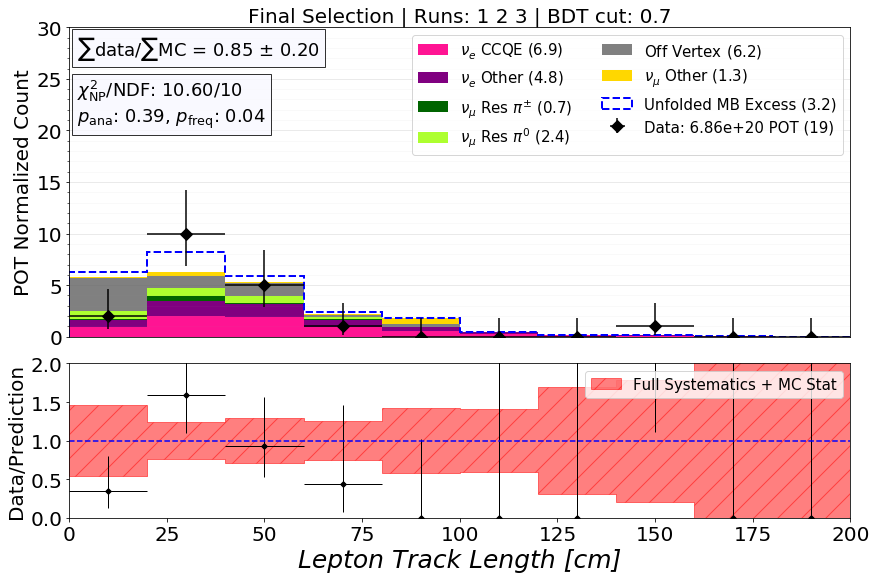

<Figure size 432x288 with 0 Axes>

In [21]:
fudge_bkg = 1.0
fudge_sig = 1.0

plot_thresh = 0.05

# Near sideband stuff
nsbmode = 3 # 1 = Enu>500, 2 = 500<Enu<700, 3 = 0.7 < BDT < 0.95, 4 = 0.01 < BDT < 0.95
nsbrwtovr = None
if nsbmode in [1,2,3]: nsbrwtovr = 'samp%i'%nsbmode
if nsbmode==3:
    range_dict['sigprob'] = (0.7,0.95)
elif nsbmode==4:
    range_dict['sigprob'] = (0.01,0.95)
elif nsbmode in [1,2]:
    range_dict['sigprob'] = (0.95,1.0)
freqp = pd.read_csv('FreqPVals/samp%i_total.txt'%nsbmode)

#Binary Settings
verbose = False
sys     = True
plotPurity = False
topplot = False
pi0wplot = False
davioplot = False
makeCutData = False if fset==10 else True

#BDT Settings
bdtmode = 'avgscore'
nBDTs = 20
bdtpower = 0
bdtcutRange = [range_dict['sigprob'][0]]


runs_to_plot = [#[1],
                #[2],
                #[3],
                [1,2,3]]

POTdict = {1:{ft:DAT_POT1 for ft in filetaglist[1]},
           2:{ft:DAT_POT2 for ft in filetaglist[2]},
           3:{ft:DAT_POT3 for ft in filetaglist[3]}}

if cutMode in [2,3] or fset==10: 
    POTdict[1]['data'] = DATA_POT_TOT
    POTdict[2]['data'] = DATA_POT_TOT
    POTdict[3]['data'] = DATA_POT_TOT
    
pvalsa = []
pvalsf = []

cls  = ['deeppink','purple','blue','cyan','darkgreen','greenyellow','gold','brown','gray','fuchsia']


    


for varName in varb_names:


    
    #if varName not in ['Enu_1e1p']: continue
    if varName=='EnuTrue' and not finalPred: continue
    
        
    xlab = varlabel_dict[varName]
        
    bins  = 12 if varName in ['Enu_1e1p','EnuQE_proton','EnuQE_lepton','EnuTrue'] else 10
    low   = (range_dict[varName])[0]
    high  = (range_dict[varName])[1]
    if nsbmode==2 and varName!='Enu_1e1p': bins/=2
    
    
    
    for runs_included in runs_to_plot: # [run 1, run 2 run 3]
        
        pRatDict = {}
        pErrDict = {}
        
        for cut in bdtcutRange:
            
            if cutMode in [0,2] and varName=='sigprob': low = cut

            if fset in range(1,8): plotTitle = 'Fake Dataset '+str(fset)+' / Runs:'
            elif cutMode==0: plotTitle = 'Final Selection | Runs:'
            elif cutMode==1: plotTitle = 'Loose Kinematic Cuts | Runs:'
            elif cutMode==2: plotTitle = 'High Energy Sideband | Runs:'
            elif cutMode==3: plotTitle = 'Low BDT Sideband | Runs:'
            plotFileName = varName
            FullPOT = 0
            POT1 = 0
            POT23 = 0

            vars_arr = []
            weights_arr = []
            labels_arr = []
            leew_arr = []
            Enu_arr = []

            dflist = []
            dfdat = pd.DataFrame()
            dflee = pd.DataFrame()
            dftot = pd.DataFrame()
            
            bkginttype = {}
            onvbkginttype = {}
            offvbkginttype = {}
            
            for r in runs_included:
                plotTitle += ' %i'%r
                plotFileName += '_%i'%r
                FullPOT += POTdict[r]['overlay']
                if r == 1: POT1 += POTdict[r]['overlay']
                elif r in [2,3]: POT23 += POTdict[r]['overlay']

                for filetag in df[r].keys():
                    if not lowEpatch and 'lowE' in filetag: continue
                    if finalPred and filetag=='data': continue
                    dfc = df[r][filetag].copy()
                            
                    if filetag!='data' or makeCutData:
                        MakeBDTcut(dfc,cut,bdtmode,nBDTs,(r==2 and filetag=='overlay'),ttc=0.1)
                    else:
                        dfc['sigprob'] = dfc['BDTscore_1e1p']
                        dfc['bdtweight'] = np.where(np.array(dfc['sigprob'])>cut,1,0)
                        dfc.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
                        if r==2 and filetag=='overlay':
                            dfc.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
                        else:
                            dfc.drop_duplicates(subset=['run','subrun','event'],inplace=True)
                    
                    
                    vars_arr += list(dfc[varName])
                    Enu_arr += list(dfc['Enu_1e1p'])
                    numu_l = np.core.defchararray.find(np.array(dfc['label'],dtype=np.string_),'m')!=-1
                    labels = np.where(np.logical_and(numu_l,dfc['scedr']>vtxCut),'offvtx',dfc['label'])
                    
                    dfc['label'] = labels
                    labels_arr += list(labels)
                    
                    
                    weights = dfc['GenieWeight'] * dfc['POTweight']**(-1)
                    if cutMode in [0,2]: weights*= dfc['bdtweight'] * dfc['sigprob']**bdtpower
                    weights*=dfc['sigprob']>range_dict['sigprob'][0]
                    weights*=dfc['sigprob']<range_dict['sigprob'][1]
                    if nsbmode in [1,2]: weights*=dfc['Enu_1e1p']>500
                    if nsbmode==2: weights*=dfc['Enu_1e1p']<700
                    weights*=dfc['Enu_1e1p']<range_dict['Enu_1e1p'][1]
                    if cutMode==0: weights*=dfc['Enu_1e1p']>200
                    
                    leeweights = dfc['LEEweight'] * weights
                    
                    if filetag!='intrinsics': leeweights*=0
                    
                    weights_arr += list(weights*POTdict[r][filetag])
                    leew_arr += list(leeweights*POTdict[r][filetag])
                    
                    dfc_lee = dfc.copy()
                    dfc['weights'] = weights*POTdict[r][filetag]
                    dfc_lee['weights'] = leeweights*POTdict[r][filetag]

                    
                    
                    if verbose:
                        dfb = dfc.query('Enu_1e1p<1200')
                        for lab,it,wt,pi0 in zip(list(dfb['label']),list(dfb['interactionType']),list(dfb['weights']),list(dfb['oldpi0flag'])):
                            if lab!='0mX' or wt<=0: continue
                            if it not in bkginttype.keys():
                                bkginttype[it] = []
                            bkginttype[it].append(wt)
                            if lab=='offvtx':
                                if it not in offvbkginttype.keys():
                                    offvbkginttype[it] = []
                                offvbkginttype[it].append(wt)
                            else:
                                if it not in onvbkginttype.keys():
                                    onvbkginttype[it] = []
                                onvbkginttype[it].append(wt)

                    if filetag=='data':
                        dfdat = pd.concat((dfdat,dfc.query('weights>0')))
                    else:
                        dflee = pd.concat((dflee,dfc_lee))
                        dftot = pd.concat((dftot,dfc))
                        dflist.append(dfc)
                
            
            if verbose:
                tot = sum([sum(v) for v in bkginttype.values()])
                print('Total',tot)
                for k,v in bkginttype.items():
                    print(k,len(v),sum(v),sum(v)/tot*100)   
                tot = sum([sum(v) for v in offvbkginttype.values()])
                print('Offv',tot)
                for k,v in offvbkginttype.items():
                    print(k,len(v),sum(v),sum(v)/tot*100)   
                tot = sum([sum(v) for v in onvbkginttype.values()])
                print('Onv',tot)
                for k,v in onvbkginttype.items():
                    print(k,len(v),sum(v),sum(v)/tot*100)
            
            
            datLab = "Data: {:.2e} POT".format(FullPOT)
            if(sys):
                rwt_sys_m,det_sys_m = getSysErrors(bins,varName,bdtmode,cut,rwtnameoverride=nsbrwtovr,nsbmode=nsbmode)
                sys_label = 'Full Systematics + MC Stat'
                if cutMode==3:
                    det_sys_m = np.zeros((bins,bins))
                    sys_label = 'Reweightable Systematics + MC Stat'
            else:
                rwt_sys_m = np.zeros((bins,bins))
                det_sys_m = np.zeros((bins,bins))
                sys_label = 'MC Stat'
            
            ## ------------------------ ##
            ## Davio Plotter: topological breakdown
            
            if topplot:
                
            
                open_Hists = StackedHisto(tuple(dflist),(np.ones(len(dflist))))
                open_Hists.AddStrata('label==\'1e1p\'',"1e1p",cls[0])
                open_Hists.AddStrata('label==\'0e1p\'',"0e1p",cls[2])
                open_Hists.AddStrata('label==\'1eX\'',"1eX",cls[1])
                open_Hists.AddStrata('label==\'1m1p\'',"1m1p",cls[3])
                open_Hists.AddStrata('label==\'0m1p\'',"0m1p",cls[3])
                open_Hists.AddStrata('label==\'1mNp\'',"1m1p",cls[3])
                open_Hists.AddStrata('label==\'0mNp\'',"0m1p",cls[3])
                open_Hists.AddStrata('label==\'1mX\'',"1mX",cls[3])
                open_Hists.AddStrata('label==\'0mX\'',"0mX",cls[3])
                open_Hists.AddStrata('label==\'0mNpi0\'',"0mNpi0",cls[4])
                open_Hists.AddStrata('label==\'1mNpi0\'',"1mNpi0",cls[5])
                open_Hists.AddStrata('label==\'offvtx\'',"offvtx",cls[8])
                open_Hists.AddStrata('label==\'EXTBNB\'','Cosmic Background',cls[9])
                if finalPred:
                    fig1,ax1 = distplot_mc(varName,bins,(low,high),open_Hists,varlabel_dict[varName])
                else:
                    open_DataHist = SimpleHisto(dfdat,1.0,0,'',datLab)
                    fig1,ax0,ax1,a = distplot_wratio_davio(varName,bins,(low,high),open_Hists,open_DataHist,varlabel_dict[varName],m_cov=rwt_sys_m+det_sys_m)
                pl = ax0.hist(list((dftot)[varName])+list((dflee)[varName]),bins=bins,range=(low,high),weights=list((dftot)['weights'])+list((dflee)['weights']),stacked='False',histtype='step',lw=2,color='blue',ls='--',label=r"LEE (%.1f)"%sum((dflee.query('Enu_1e1p<1200'))['weights']))
                ax0.legend(ncol=2,fontsize=25,loc='upper right')
                ax0.set_xticks([])
                plt.setp(ax1.get_xticklabels(), fontsize=20)
                plt.setp(ax0.get_yticklabels(), fontsize=20)
                plt.setp(ax1.get_yticklabels(), fontsize=20)
                
                #ax1.set_ylim((0,5*max(pl[0])))
                ax0.set_title(plotTitle,fontsize=30)
                plt.tight_layout()
                plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_TopPlot.png',dpi=100)
                plt.show()
                pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_TopPlot.pickle',  'wb')  )
                plt.clf()                
                continue

            ## ------------------------ ##
            
            
            
            if cutMode in [0,2]: plotTitle += r' | BDT cut: '+str(cut)

            label_arr = np.array(labels_arr)
            var_arr = np.array(vars_arr)
            enu_arr = np.array(Enu_arr)
            weight_arr = np.array(weights_arr)

            data = list(var_arr[label_arr=='data'])
            if nsbmode==1: dataOld = list(var_arr[np.logical_and(label_arr=='data',enu_arr>700)])
            nueO = list(var_arr[label_arr=='nue_ccqe'])
            nue = list(var_arr[label_arr=='nue_other'])
            ccqe = list(var_arr[label_arr=='numu_ccqe'])
            mec = list(var_arr[label_arr=='numu_mec'])
            pipm = list(var_arr[label_arr=='numu_pipm'])
            pi0 = list(var_arr[label_arr=='numu_pi0'])
            other = list(var_arr[label_arr=='numu_other'])
            dirtVar = []
            offv = list(var_arr[label_arr=='offvtx'])
            extVar = list(var_arr[label_arr=='EXTBNB'])
            lee = list(var_arr)

            ovrw1 = list(fudge_bkg*weight_arr[label_arr=='numu_ccqe'])
            ovrw2 = list(fudge_bkg*weight_arr[label_arr=='numu_mec'])
            ovrw3 = list(fudge_bkg*weight_arr[label_arr=='numu_pipm'])
            ovrw4 = list(fudge_bkg*weight_arr[label_arr=='numu_pi0'])
            ovrw5 = list(fudge_bkg*weight_arr[label_arr=='numu_other'])
            ovrw6 = list(fudge_bkg*weight_arr[label_arr=='offvtx'])
            ovrw7 = list(fudge_sig*weight_arr[label_arr=='nue_other'])
            ovrw8 = list(fudge_sig*weight_arr[label_arr=='nue_ccqe'])
            dirtw = []
            extw = list(weight_arr[label_arr=='EXTBNB'])
            leew = leew_arr
            datw = list(weight_arr[label_arr=='data'])
            if nsbmode==1: datwOld = list(weight_arr[np.logical_and(label_arr=='data',enu_arr>700)])
            


            d      = plt.hist(data,weights=datw,bins=bins,range=(low,high),normed=0)
            xbins  = [(d[1][i]+d[1][i+1])/2.0 for i in range(len(d[1])-1)]
            xbin_edges = d[1]
            vals = d[0]
            valerrs = poisson_errors(vals)
            binwid = d[1][0]-d[1][1]
            if nsbmode==1:
                dOld      = plt.hist(dataOld,weights=datwOld,bins=bins,range=(low,high),normed=0)
                valsOld = dOld[0]
                valerrsOld = poisson_errors(valsOld)
            plt.clf()
            
            if verbose:
                A = float(len(ovrw8))
                B = float(sum(np.array(ovrw8)>0))
                print('raw CCQE before cut:',A,'+-',np.sqrt(A))
                print('raw CCQE after cut:',B,'+-',np.sqrt(B))
                print('CCQE accuracy:',B/A,'+-',B/A * np.sqrt(1/A + 1/B))
            



            wghs = [[x for x in ovrw8],
                    [x for x in ovrw7],
                    [x for x in ovrw1],
                    [x for x in  ovrw2],
                    [x for x in ovrw3],
                    [x for x in  ovrw4],
                    [x for x in ovrw5],
                    [x for x in dirtw],
                    [x for x in ovrw6],
                    [x for x in extw],
                    [x for x in leew]]

            mcErW = [[x**2 for x in ovrw8],
                     [x**2 for x in ovrw7],
                     [x**2 for x in ovrw1],
                     [x**2 for x in  ovrw2],
                     [x**2 for x in ovrw3],
                     [x**2 for x in  ovrw4],
                     [x**2 for x in ovrw5],
                     [x**2 for x in dirtw],
                     [x**2 for x in ovrw6],
                     [x**2 for x in extw]]
            


            r = plt.hist([nueO,nue,ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar],bins=bins,range=(low,high),stacked='True',normed=0,weights=mcErW)
            nueO_mcErr  = [sqrt(r[0][0][i]- 0) for i in range(bins)]
            nue_mcErr   = [sqrt(r[0][1][i]-r[0][0][i]) for i in range(bins)]
            ccqe_mcErr  = [sqrt(r[0][2][i]-r[0][1][i]) for i in range(bins)]
            mec_mcErr   = [sqrt(r[0][3][i]-r[0][2][i]) for i in range(bins)]
            pipm_mcErr  = [sqrt(r[0][4][i]-r[0][3][i]) for i in range(bins)]
            pi0_mcErr   = [sqrt(r[0][5][i]-r[0][4][i]) for i in range(bins)]
            other_mcErr = [sqrt(r[0][6][i]-r[0][5][i]) for i in range(bins)]
            dirt_mcErr  = [sqrt(r[0][7][i]-r[0][6][i]) for i in range(bins)]
            offv_mcErr  = [sqrt(r[0][8][i]-r[0][7][i]) for i in range(bins)]
            ext_mcErr   = [sqrt(r[0][9][i]-r[0][8][i]) for i in range(bins)]
            stkerr =  [sqrt( 
                       nueO_mcErr[i]**2  + 
                       nue_mcErr[i]**2  + 
                       ccqe_mcErr[i]**2  + 
                       mec_mcErr[i]**2  + 
                       pipm_mcErr[i]**2  + 
                       pi0_mcErr[i]**2  + 
                       other_mcErr[i]**2  + 
                       dirt_mcErr[i]**2 + 
                       offv_mcErr[i]**2 +  
                       ext_mcErr[i]**2 )
                       for i in range(bins) 
                      ]
            stkerr = np.array(stkerr)
            bkgErr = sum([ (ccqe_mcErr[i]**2  + 
                       mec_mcErr[i]**2  + 
                       pipm_mcErr[i]**2  + 
                       pi0_mcErr[i]**2  + 
                       other_mcErr[i]**2  + 
                       dirt_mcErr[i]**2 + 
                       offv_mcErr[i]**2 +  
                       ext_mcErr[i]**2 )
                       for i in range(bins) 
                      ])


            if(verbose):
                print(nueO_mcErr)
                print(stkerr)
                print(bkgErr)

            plt.clf()

            pli = plt.hist([nueO,nue,ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar,lee],bins=bins,range=(low,high),weights=wghs,stacked='True',normed=0)
            plt.clf()

            nums = [sum(x for x in pli[0][0]           ),
                    sum(x for x in pli[0][1] -pli[0][0]),
                    sum(x for x in pli[0][2] -pli[0][1]),
                    sum(x for x in pli[0][3] -pli[0][2]),
                    sum(x for x in pli[0][4] -pli[0][3]),
                    sum(x for x in pli[0][5] -pli[0][4]),
                    sum(x for x in pli[0][6] -pli[0][5]),
                    sum(x for x in pli[0][7] -pli[0][6]),
                    sum(x for x in pli[0][8] -pli[0][7]),
                    sum(x for x in pli[0][9] -pli[0][8]),        
                    sum(x for x in pli[0][10]-pli[0][9]),
                    sum(x for x in vals)
                    ]


            labs = [r'$\nu_e^{ }$ CCQE (%.1f)'%nums[0],
                    r'$\nu_e^{ }$ Other (%.1f)'%nums[1],
                    r"$\nu_\mu^{ }$ CCQE (%.1f)"%nums[2],
                    r"$\nu_\mu$ MEC (%.1f)"%nums[3],
                    r"$\nu_\mu$ Res $\pi^{\pm}$ (%.1f)"%nums[4],
                    r"$\nu_\mu$ Res $\pi^0$ (%.1f)"%nums[5],
                    r"$\nu_\mu^{ }$ Other (%.1f)"%nums[6],
                    r"Dirt$_{ }^{ }$ (%.1f)"%nums[7],
                    r"Off Vertex$_{ }^{ }$ (%.1f)"%nums[8],
                    "External (%.1f)"%nums[9]]
            
            
            ## ----------------------- ##
            
            cats = [ccqe,mec,pipm,pi0,other,dirtVar,offv,extVar]
            cats_to_plot = [nueO,nue]
            labs_to_plot = [labs[0],labs[1]]
            wghs_to_plot = [wghs[0],wghs[1]]
            cls_to_plot = [cls[0],cls[1]]
            other_to_plot = other
            other_wghs = wghs[6]
            other_num = nums[6]
            for i,(n,l,w,cl,c) in enumerate(zip(nums[2:10],labs[2:10],wghs[2:10],cls[2:10],cats)):
                if 'Other' in l: continue
                if n>plot_thresh:
                    cats_to_plot.append(c)
                    wghs_to_plot.append(w)
                    labs_to_plot.append(l)
                    cls_to_plot.append(cl)
                else:
                    other_to_plot+=c
                    other_num+=n
                    other_wghs+=w
            cats_to_plot.append(other_to_plot)
            cls_to_plot.append(cls[-4])
            labs_to_plot.append(r"$\nu_\mu^{ }$ Other (%.1f)"%other_num)
            wghs_to_plot.append(other_wghs)
                
            


            fig, ax = plt.subplots(figsize=(14,9.5))
            plt.subplot2grid((100,100),(0,0),colspan=100,rowspan=60)

            p = plt.hist(cats_to_plot,bins=bins,range=(low,high),weights=wghs_to_plot,stacked='True',color=cls_to_plot,label=labs_to_plot,normed=0)
            pl =plt.hist(nueO+nue+ccqe+mec+pipm+pi0+other+dirtVar+offv+extVar+lee,bins=bins,range=(low,high),weights=wghs[0]+wghs[1]+wghs[2]+wghs[3]+wghs[4]+wghs[5]+wghs[6]+wghs[7]+wghs[8]+wghs[9]+wghs[10],stacked='False',histtype='step',lw=2,color='blue',ls='--',label="Unfolded MB Excess (%.1f)"%nums[10])
            if not finalPred:
                #if nsbmode==1: plt.errorbar(xbins,valsOld,xerr=binwid/2,yerr=valerrsOld,marker='o',fillstyle='none',ls='None',color='black',ms=8,label=r"$E_\nu^{\rm Range}>700$ MeV (%i)"%sum(valsOld),elinewidth=1.5)
                plt.errorbar(xbins,vals,xerr=binwid/2,yerr=valerrs,marker='D',ls='None',color='black',ms=8,label="%s (%i)"%(datLab,nums[11]),elinewidth=1.5)
            
            if nsbmode==3: 
                
            
                if varName=='Enu_1e1p':
                    bkg_7 = np.loadtxt('BackgroundFitterOutput/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/CDF/avgscore/bkg7.txt')[1:]
                    bkg_95 = np.loadtxt('BackgroundFitterOutput/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/CDF/avgscore/bkg95.txt')[1:]
                    bkgmid = bkg_7-bkg_95
                    plt.errorbar(xbins[2:],p[0][1][2:]+bkgmid,yerr=0,xerr=binwid/2,fmt='.',label=r'$\nu_\mu$ Background Fit + $\nu_e$ MC',color='red',linewidth=4)
            
            if verbose:
                print('Bin by bin prediction:',p[0][-1])
                print('Bin by bin nue prediction:',p[0][1])
                print('Bin by bin numu prediction:',p[0][-1]-p[0][1])
                print('Total prediction:',sum(p[0][-1]))
                print('Data:',vals)
            
            ylow  = 0
            yhigh = 3.0*max(vals)
            if finalPred: 
                if varName=='Enu_1e1p': yhigh = 3*len(runs_included)
                else: yhigh = 2.0*max(p[0][-1])

            
            major_xticks = arange(low, high*1.01, 20)
            minor_xticks = arange(low, high*1.01, 5)
            major_yticks = arange(ylow, yhigh+1, 50)
            minor_yticks = arange(ylow, yhigh+1, 10)
            
            
            
            if not finalPred:
                cov = np.zeros((bins,bins))
                for j in range(bins):
                    cov[j][j] = cov_cnp(vals[j],p[0][-1][j]) + stkerr[j]**2
                
                det_sys_m = getDetSysTot(det_sys_m,p[0][1],p[0][-1]-p[0][1])
                print(det_sys_m)
                print(rwt_sys_m)
                cov += det_sys_m * np.outer(p[0][-1],p[0][-1])
                cov += rwt_sys_m * np.outer(p[0][-1],p[0][-1])
                

                mask1D = np.where(p[0][-1]==0,False,True)
                mask2D = np.outer(mask1D,mask1D)#np.where(cov==0,False,True)
                
                

                Del = (vals - p[0][-1])[mask1D]
                cov = cov[mask2D].reshape((len(Del),len(Del)))

                chi2 = np.matmul(np.matmul(Del,np.linalg.inv(cov)),Del)
                pval = 1 - stats.chi2.cdf(chi2,len(Del))
                pvalsa.append(pval)
                
                if nsbmode==3 and varName=='Enu_1e1p':
                    Delfit = (vals[2:] - (p[0][1][2:]+bkgmid))

                    chi2fit = np.matmul(np.matmul(Delfit,np.linalg.inv(cov)),Delfit)
                    pvalfit = 1 - stats.chi2.cdf(chi2fit,len(Delfit))
           

            rwt_sys = np.array([rwt_sys_m[j][j] for j in range(bins)])
            det_sys = np.array([det_sys_m[j][j] for j in range(bins)])
            sys_errs = np.sqrt(rwt_sys + det_sys + stkerr**2/p[0][-1]**2)        
            
            sys_low = np.append((p[0][-1] * (1 - sys_errs)),0)
            
            rsys_low = np.append(1-sys_errs,(1-sys_errs)[-1])
            sys_high = np.append((p[0][-1] * (1 + sys_errs)),0)
            
            rsys_high = np.append(1+sys_errs,(1+sys_errs)[-1])
            
            sys_low = np.where(np.isnan(sys_low),0,sys_low)
            sys_high = np.where(np.isnan(sys_high),0,sys_high)
            rsys_low = np.where(np.isnan(rsys_low),1,rsys_low)
            rsys_high = np.where(np.isnan(rsys_high),1,rsys_high)
            #plt.fill_between(xbin_edges,sys_low,sys_high,step='post',hatch='/',label=sys_label,color='red',edgecolor='black',alpha=0.5)

                

            plt.title(plotTitle,fontsize=20)
            plt.legend(loc='upper right',fontsize=15,ncol=2)
            plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.17)
            plt.minorticks_on()
            plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.07)
            plt.yticks(fontsize=20)
            ax.set_yticks(major_yticks)
            ax.set_yticks(minor_yticks,minor=True)
            plt.xticks([])
            plt.ylim((ylow,yhigh))
            plt.xlim((low,high))
            if cutMode in [0,2] and varName=='Enu_1e1p': plt.xlim((200,high))
            #plt.semilogy()
            plt.ylabel("POT Normalized Count",fontsize=20)
            
            if not finalPred:
                plt.annotate(r'$\sum$data/$\sum$MC = %.2f $\pm$ %.2f'%(vals.sum()/float(p[0][-1].sum()),np.sqrt(vals.sum())/float(p[0][-1].sum())),xy=(0.01,.91),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                try:
                    plt.annotate(r'$\chi^2_{\rm NP}$/NDF: %2.2f/%i'%(chi2,len(Del))+'\n'+r'$p_{\rm ana}$: %2.2f, $p_{\rm freq}$: %2.2f'%(pval,float(freqp.query('varName==@varName')['p'])),xy=(0.01,.69),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                    print(float(freqp.query('varName==@varName')['chi2']))
                    pvalsf.append(float(freqp.query('varName==@varName')['p']))
                except:
                    plt.annotate(r'$\chi^2_{\rm NP}$/NDF: %2.2f/%i'%(chi2,len(Del))+'\n'+r'$p_{\rm ana}$: %2.2f, $p_{\rm freq}$: N/A'%(pval),xy=(0.01,.69),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                    
                    
                if nsbmode==3 and varName=='Enu_1e1p':
                    plt.annotate(r'$\chi^2_{\rm NP,fit}$/NDF: %2.2f/%i'%(chi2fit,len(Del))+'\n'+r'$p_{\rm ana,fit}$: %2.2f'%(pvalfit),xy=(0.07,.49),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                



            plt.subplot2grid((100,100),(65,0),colspan=100,rowspan=30)

            rat    = [vals[i]/p[0][-1][i] for i in range(bins)]
            raterr = ([valerrs[0][i]/p[0][-1][i] if p[0][-1][i] > 0 else sqrt(2) for i in range(bins)],[valerrs[1][i]/p[0][-1][i] if p[0][-1][i] > 0 else sqrt(2) for i in range(bins)])
            if not finalPred: plt.errorbar(xbins,rat,yerr=raterr,xerr=binwid/2.0,marker='D',ls='None',color='black',ms=4,elinewidth=1)
            
            plt.fill_between(xbin_edges,rsys_low,rsys_high,step='post',hatch='/',label=sys_label,color='red',edgecolor='black',alpha=0.5)
            if finalPred and varName=='Enu_1e1p' and runs_included==[1,2,3]:
                
                
                cons_sys_low = rsys_low
                cons_sys_high = rsys_high
                cons_sys = np.array([0.20901378808739082,
                                    0.1444013176174152,
                                    0.12968704285562785,
                                    0.10899892762530568,
                                    0.09921274905778553,
                                    0.13171895464815286,
                                    0.12074490444040405,
                                    0.15485056693126997,
                                    0.21437910258176504,
                                    0.2357440794006659,0])
                cons_sys_low[2:] = 1 - cons_sys
                cons_sys_high[2:] = 1 + cons_sys
            
                #plt.fill_between(xbin_edges,cons_sys_low,cons_sys_high,step='post',hatch='/',label='Constrained Uncertainties',color='blue',edgecolor='black',alpha=0.5)
            
            
            plt.legend(loc='upper right',fontsize=15,ncol=1)
            plt.axhline(y=1.0,ls='--',color='blue')
            plt.xlabel(xlab,fontsize=25,style='italic')
            plt.ylabel("Data/Prediction",fontsize=20)
            plt.ylim((0,2))
            plt.xlim((low,high))
            if cutMode in [0,2] and varName=='Enu_1e1p': plt.xlim((200,high))
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            ax.set_xticks(major_xticks)
            ax.set_xticks(minor_xticks,minor=True)
            
            
            plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_cutLevel3.png',dpi=100)
            plt.show()
            pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_cutLevel3.pickle',  'wb')  )
            plt.clf()

            sig = p[0][0]
            bkg = p[0][-1] - p[0][0]
            if verbose: 
                A = sum(sig)
                B = sum(sig)+sum(bkg)
                errA = sqrt(sum(np.array(nueO_mcErr)**2))
                errB = sqrt(sum(stkerr**2))
                print('POT scaled nue:',A,'+-',errA)
                print('POT scaled total:',B,'+-',errB)
                print('Purity:',A/B,'+-',A/B*np.sqrt(errA**2/A**2 + errB**2/B**2))
                if varName=='Enu_1e1p':
                    print('Nue Spectrum:',sig)
                    print('LEE:',pl[0]-(sig+bkg))
                    print('Bkg Spectrum:',bkg)
                    print('Bkg sum of weights squared:',bkgErr)
                    print('POT scaled numu rate:',sum(bkg))
                
            #print(sum(sig[2:5])/(sum(sig[2:5])+sum(bkg[2:5])))
            #print(sum(sig)/(sum(sig)+sum(bkg)))

            if plotPurity:
                purityRat = sig / (sig+bkg)
                pratErr = np.sqrt((1.0/(sig+bkg))**2*np.array(nueO_mcErr)**2 +
                                 (sig/(sig+bkg)**2)**2*np.array(stkerr)**2)
                pratErr = np.where(np.logical_or(np.isinf(purityRat),np.isnan(purityRat)),1,pratErr)
                purityRat = np.where(np.logical_or(np.isinf(purityRat),np.isnan(purityRat)),1,purityRat)
                plt.errorbar(xbins,purityRat,yerr=pratErr,fmt='.',capsize=3)
                plt.xlabel(xlab)
                plt.title('Purity')
                plt.ylim(0,1)
                plt.ylabel(r'$\frac{sig}{sig + bkg}$',fontsize=15)
                plt.show()
                plt.clf()
                
            ## ------------------------ ##
            ## Davio Plotter
            
            if davioplot:
                open_Hists = StackedHisto(tuple(dflist),(np.ones(len(dflist))))
                open_Hists.AddStrata('label==\'nue_ccqe\'',r"$\nu_e$ CCQE",cls[0])
                open_Hists.AddStrata('label==\'nue_other\'',r"$\nu_e$ Other",cls[1])
                open_Hists.AddStrata('label==\'numu_ccqe\'',r"$\nu_\mu$ CCQE",cls[2])
                open_Hists.AddStrata('label==\'numu_mec\'',r"$\nu_\mu$ MEC",cls[3])
                open_Hists.AddStrata('label==\'numu_pipm\'',r"$\nu_\mu$ $\pi^\pm$",cls[4])
                open_Hists.AddStrata('label==\'numu_pi0\'',r"$\nu_\mu$ $\pi^0$",cls[5])
                open_Hists.AddStrata('label==\'numu_other\'',r"$\nu_\mu$ Other",cls[6])
                open_Hists.AddStrata('label==\'offvtx\'',r"Off Vertex",cls[8])
                open_Hists.AddStrata('label==\'EXTBNB\'','Cosmic Background',cls[9])
                if finalPred:
                    fig1,ax1 = distplot_mc(varName,bins,(low,high),open_Hists,varlabel_dict[varName])
                else:
                    open_DataHist = SimpleHisto(dfdat,1.0,0,'',datLab)
                    fig1,ax1,_,a = distplot_wratio_davio(varName,bins,(low,high),open_Hists,open_DataHist,varlabel_dict[varName],m_cov=rwt_sys_m+det_sys_m)
                pl = ax1.hist(list(dftot[varName])+list(dflee[varName]),bins=bins,range=(low,high),weights=list(dftot['weights'])+list(dflee['weights']),stacked='False',histtype='step',lw=2,color='blue',ls='--',label="Unfolded MB Excess (%.1f)"%nums[10])
                ax1.legend(ncol=2,fontsize=16,loc='upper right')
                #ax1.set_ylim((0,5*max(pl[0])))
                ax1.set_title(plotTitle,fontsize=30)
                plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_DavioPlot.png',dpi=100)
                plt.show()
                pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_DavioPlot.pickle',  'wb')  )
                plt.clf()              

            ## ------------------------ ##
            
            ## ------------------------ ##
            ## Davio Plotter: pi0 weight breakdown
            
            if pi0wplot:
            
                open_Hists = StackedHisto(tuple(dflist),(np.ones(len(dflist))))
                open_Hists.AddStrata('(label==\'nue_ccqe\' or label==\'nue_other\') and not oldpi0flag',r"$\nu_e$ w/o $\pi^0$",cls[0])
                open_Hists.AddStrata('(label==\'nue_ccqe\' or label==\'nue_other\') and oldpi0flag',r"$\nu_e$ w/ $\pi^0$",cls[1])
                open_Hists.AddStrata('(not (label==\'nue_ccqe\' or label==\'nue_other\')) and not oldpi0flag',r"$\nu_\mu$ w/o $\pi^0$",cls[2])
                open_Hists.AddStrata('(not (label==\'nue_ccqe\' or label==\'nue_other\')) and oldpi0flag',r"$\nu_\mu$ w/ $\pi^0$",cls[5])
                fig1,ax1 = distplot_mc(varName,bins,(low,high),open_Hists,varlabel_dict[varName])
                plt.hist(list((dftot)[varName])+list((dflee.query('newpi0flag'))[varName]),bins=bins,range=(low,high),weights=list((dftot)['weights'])+list((dflee.query('newpi0flag'))['weights']),stacked='False',histtype='step',lw=2,color='red',ls='--',label=r"LEE w/ $\pi^0$ (%.1f)"%sum((dflee.query('newpi0flag and Enu_1e1p < 1200'))['weights']))
                pl = plt.hist(list((dftot)[varName])+list((dflee.query('not newpi0flag'))[varName]),bins=bins,range=(low,high),weights=list((dftot)['weights'])+list((dflee.query('not newpi0flag'))['weights']),stacked='False',histtype='step',lw=2,color='blue',ls='--',label=r"LEE w/o $\pi^0$ (%.1f)"%sum((dflee.query('not newpi0flag and Enu_1e1p < 1200'))['weights']))

                plt.legend(ncol=3,fontsize=18)
                plt.ylim((0,1.5*max(pl[0])))
                plt.show()                

            ## ------------------------ ##
            
            
            

            

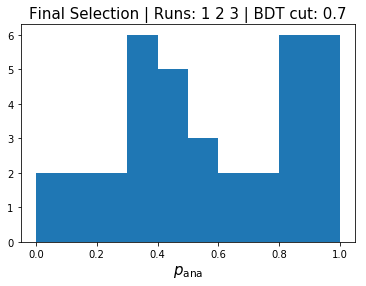

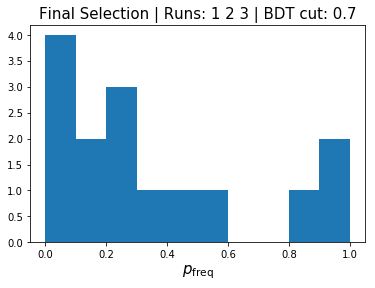

<Figure size 432x288 with 0 Axes>

In [9]:
if not finalPred:
    plt.hist(pvalsa,bins=10,range=(0,1))
    plt.xlabel(r'$p_{\rm ana}$',fontsize=15)
    plt.title(plotTitle,fontsize=15)
    plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+'pvalsa.png')         
    plt.show()
    pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+'pvalsa.pickle',  'wb')  )
    plt.clf()
    
    plt.hist(pvalsf,bins=10,range=(0,1))
    plt.xlabel(r'$p_{\rm freq}$',fontsize=15)
    plt.title(plotTitle,fontsize=15)
    plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+'pvalsf.png')         
    plt.show()
    pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+'pvalsf.pickle',  'wb')  )
    plt.clf()

In [ ]:
tsavedir = 'TextFiles/'+tag+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
for bdtmode in ['avgscore','fracweight','medianscore']:
    tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'+bdtmode+'/'
    try: os.mkdir(tsavedir)
    except OSError as error: print(error)
    for r in [1,2,3]:
        for filetag in df[r].keys():
            if not lowEpatch and 'lowE' in filetag: continue
            #if not 'data' in filetag: continue
            dfc = df[r][filetag].copy()
            SaveTextFile(dfc,r,filetag+'_fset%i'%fset,0.0,bdtmode,tsavedir)